https://www.udemy.com/course/python-for-data-science-and-machine-learning-bootcamp/learn/lecture/5733448#overview

http://localhost:8888/notebooks/02-Topic/P02-Classification/S1-Logistic%20Regression/01-Logistic%20Regression%20with%20Python.ipynb

<h1 align = "center"> TITANIC ANALYSIS </h1> 

In [1]:
# Dataframe manipulation
import numpy as np
import pandas as pd
# To analyze the type of missing data
import missingno as msno
import UtilityFunction

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = 'whitegrid',context = 'notebook')

# Preprocessing
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer, LabelEncoder, scale
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, scale

# Modelling Helpers:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, ShuffleSplit, cross_validate
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,ElasticNet,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Evaluation metrics for Regression 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
# Evaluation metrics for Classification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

Setup complete...


-----------------------------------------------------------------------------------------------------------------
# 3. Common function
-----------------------------------------------------------------------------------------------------------------

In [2]:
#######################################################################
### DefineTarget
#######################################################################
def DefineTarget(target_val):
    if(target_val == 'Yes'):
        target_val = 1
    else:
        target_val = 0
    
    return target_val


#######################################################################
### Descriptive Statistics
#######################################################################
def DescriptiveStatistics(df):
    countvar = df.count()
    meanvar = np.round(df.mean(),1)
    minvar = df.min()
    maxvar = df.max()
    stdvar = np.round(df.std(),1)
    statistics_df = pd.concat([meanvar,minvar,maxvar,stdvar,countvar],axis=1)
    statistics_df = pd.DataFrame(statistics_df).reset_index()
    orgname = list(statistics_df.columns.values)
    statistics_df.rename(columns={orgname[0]:'variable',
                                  orgname[1]:'mean',
                                  orgname[2]:'min',
                                  orgname[3]:'max',
                                  orgname[4]:'std',
                                  orgname[5]:'non_missing'},
                                  inplace = True)
    statistics_df['Total'] = df.shape[0]
    statistics_df['miss_per'] = np.round(100*(statistics_df['Total'] - statistics_df['non_missing'])/statistics_df['Total'],1)
    
    return statistics_df


#######################################################################
### Check_Missing_Data
#######################################################################
def Check_Missing_Data(df):    
    # count all missing values of each column
    total = df.isnull().sum().sort_values(ascending=False)
    # calculate percentage of null values for each column
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    return missing_data


#######################################################################
### Create dummy varibales
#######################################################################
def CreateDummyVar(df, categorical_list):
    objdf_new = df.copy()
    objdf_dummy =pd.DataFrame()
    i = 0
    for e in categorical_list:
        i = i + 1
        objdf_new[e]=objdf_new[e] + "_" + str(i)
        varname= e 
        df_temp = pd.get_dummies(objdf_new[varname])
        objdf_dummy = pd.concat([objdf_dummy, df_temp], axis=1)
        
    return objdf_dummy


#######################################################################
### Check frequency of each level in categorical variable
#######################################################################
def analyse_frequency_labels(df, var):
    df = df.copy()
    df['id'] = df.index.values
    tmp = df.groupby(var)['id'].count()/len(df)
    return tmp


#######################################################################
### Levels that are present only in a small number
#######################################################################
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()
    df['id'] = df.index.values
    tmp = df.groupby(var)['id'].count()/len(df)
    return tmp[tmp < rare_perc]


#######################################################################
### ModelSelection
#######################################################################
def ModelSelection(X_train, y_train, X_test, y_test):
    
    # Import libraries
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB
    from lightgbm import LGBMClassifier
    from sklearn.svm import SVC, LinearSVC
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
    from xgboost import XGBClassifier
    from sklearn.neural_network import MLPClassifier
    
    # Test options and evaluation metric
    seed = 7
    scoring = 'accuracy'
    
    # Initialize the classifier models with their default parameters and add them to the list
    models = []
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVC', SVC(kernel="linear")))
    models.append(('LSVC', SVC(kernel="rbf")))
    models.append(('LR', LogisticRegression()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('GNB', GaussianNB()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGB',LGBMClassifier()))
    models.append(('ADA',AdaBoostClassifier()))
    models.append(('QDA',QuadraticDiscriminantAnalysis()))
    models.append(('NN',MLPClassifier()))
    models.append(('XGB',XGBClassifier()))
    
    # Train model
    # evaluate each model in turn
    from sklearn import model_selection
    from sklearn.model_selection import train_test_split
    results = {}
    names = []

    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state = seed)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results[name] = cv_results
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    
    results_df = pd.DataFrame(results)
    print(results_df)
    
    plt.figure(figsize=(15,10))
    sns.boxplot(data=results_df)
    plt.show()
    
    # Make predictions on validation dataset
    for name, model in models:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(name)
        print('Accuracy score: ',accuracy_score(y_test, predictions))
        print(classification_report(y_test, predictions))

------------------------------------------------------------------------------------------------------------------
# 4. Import Dataset
------------------------------------------------------------------------------------------------------------------

In [3]:
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

train_df.head()

,Age,Fare,Parch,SibSp,Pclass,Embarked_Q,Embarked_S,Sex_male,Target
0,0.384267,0.051237,0.166667,0.125,0.5,0,1,1,0
1,0.447097,0.025130,0.000000,0.000,0.5,0,0,1,0
2,0.308872,0.015379,0.000000,0.000,1.0,1,0,0,1
3,0.308872,0.107353,0.166667,0.000,0.0,0,1,0,1
4,0.220910,0.035134,0.000000,0.250,1.0,0,1,0,0


In [4]:
print(train_df.shape)
print(test_df.shape)

(700, 9)
(176, 9)


In [6]:
removed_list = ['Target']
selected_features = [x for x in train_df.columns.values if x not in removed_list]
# reduce the train and test set to the desired features
X_train = train_df[selected_features]
X_test = test_df[selected_features]
X = pd.concat([X_train,X_test],axis=0)

In [7]:
# capture the target
# y_train = pd.Series(np.log(train_df['price']))
# y_test = pd.Series(np.log(test_df['price']))
y_train = pd.Series(train_df['Target'])
y_test = pd.Series(test_df['Target'])
y = pd.concat([y_train,y_test],axis=0)

# PART 10: MODEL BUILDING

## 10.1 - Logistic Regression
<a id="LogisticRegression"></a>

### 10.1.1 Train model

#### Train - Test split

In [7]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### K-Fold Cross Validation

In [8]:
cv_classifier = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

### 10.1.2 Creating Summary Table

#### Find the intercept and coefficients

In [9]:
classifier.intercept_

array([1.31951163])

In [10]:
classifier.coef_

array([[-0.52169404,  0.12298592, -0.11266083, -0.23263544, -0.89482695,
        -0.06802053, -0.35830983, -2.58405913]])

#### Summary table

In [11]:
UtilityFunction.LogisticSummaryTable(classifier, X)

,feature_name,Coefficient,Odds_ratio
0,Intercept,1.319512,3.741594
1,Age,-0.521694,0.593514
2,Fare,0.122986,1.130869
3,Parch,-0.112661,0.893454
4,SibSp,-0.232635,0.792442
5,Pclass,-0.894827,0.408678
6,Embarked_Q,-0.068021,0.934241
7,Embarked_S,-0.358310,0.698857
8,Sex_male,-2.584059,0.075467


#### Prediction & Evaluation

In [12]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.8006088280060882
ROC AUC Score:  0.8526357044875563
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       405
           1       0.76      0.71      0.73       252

    accuracy                           0.80       657
   macro avg       0.79      0.78      0.79       657
weighted avg       0.80      0.80      0.80       657

-----------------------------------------------------------
Test set
Accuracy:  0.7945205479452054
ROC AUC Score:  0.8774250440917108
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       135
           1       0.72      0.75      0.74        84

    accuracy                           0.79       219
   macro avg       0.78      0.79      0.78       219
weighted avg       0.80      0.79      0.80       219



### 10.1.3 Tuning hyper parameters

#### Apply Grid Search

In [13]:
params = {'C': [0.01,0.1,1,10,100,1000]}
grid_clf = GridSearchCV(LogisticRegression(), params, refit=True, scoring = 'accuracy', cv = 10, verbose = 2)

#### KFold Cross Validation

In [14]:
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s finished


{'C': 0.1}

#### Re-run with the best parameters

In [15]:
classifier = grid_clf.best_estimator_
classifier.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
cv_classifier = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

### 10.1.4 Predicting

In [17]:
prob_train_pred = classifier.predict_proba(X_train)
prob_test_pred = classifier.predict_proba(X_test)
prob_test_pred[0:5]

array([[0.47780643, 0.52219357],
       [0.43662335, 0.56337665],
       [0.34068021, 0.65931979],
       [0.38351402, 0.61648598],
       [0.79977754, 0.20022246]])

In [18]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

In [19]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.8036529680365296
ROC AUC Score:  0.8520968058005094
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       405
           1       0.78      0.68      0.73       252

    accuracy                           0.80       657
   macro avg       0.80      0.78      0.79       657
weighted avg       0.80      0.80      0.80       657

-----------------------------------------------------------
Test set
Accuracy:  0.7945205479452054
ROC AUC Score:  0.8744268077601411
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       135
           1       0.73      0.73      0.73        84

    accuracy                           0.79       219
   macro avg       0.78      0.78      0.78       219
weighted avg       0.79      0.79      0.79       219



### 10.1.5 Evaluating model

#### Summary

In [20]:
result_summary = pd.DataFrame(columns= ['Dataset',"accuracy", "roc_auc_score", "recall", "precision"] )
result_summary.loc[0,:] = ['Train',accuracy_score(y_train, y_train_pred), roc_auc_score(y_train, prob_train_pred[:,1]),recall_score(y_train, y_train_pred),precision_score(y_train, y_train_pred)]
result_summary.loc[1,:] = ['Test',accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, prob_test_pred[:,1]),recall_score(y_test, y_test_pred),precision_score(y_test, y_test_pred)]
result_summary

,Dataset,accuracy,roc_auc_score,recall,precision
0,Train,0.803653,0.852097,0.678571,0.780822
1,Test,0.794521,0.874427,0.72619,0.73494


#### Overall Accuracy

In [21]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.8036529680365296
0.7945205479452054
0.7959440559440558 0.06878567887418796


In [22]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.804 , Test: 0.795, Validation: 0.796


#### Confusion Matrix

True         0    1
Predicted          
0          357   48
1           81  171


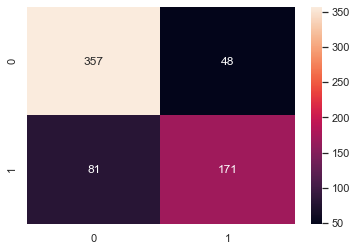

In [23]:
# Training set
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

Normalized confusion matrix
[[0.88148148 0.11851852]
 [0.32142857 0.67857143]]


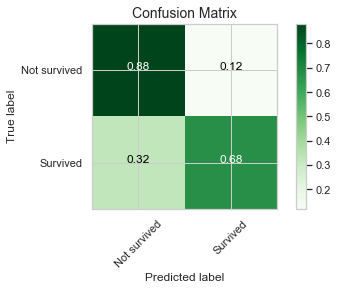

In [24]:
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=True)

True         0   1
Predicted         
0          113  22
1           23  61


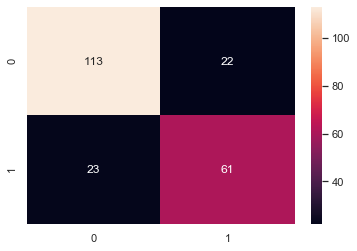

In [25]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

Normalized confusion matrix
[[0.83703704 0.16296296]
 [0.27380952 0.72619048]]


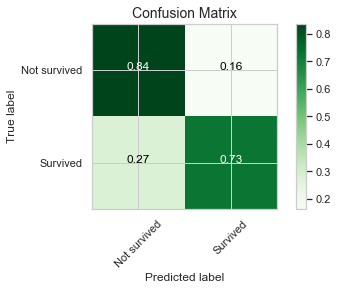

In [26]:
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=True)

#### Classification Report

In [27]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       405
           1       0.78      0.68      0.73       252

    accuracy                           0.80       657
   macro avg       0.80      0.78      0.79       657
weighted avg       0.80      0.80      0.80       657



In [28]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       135
           1       0.73      0.73      0.73        84

    accuracy                           0.79       219
   macro avg       0.78      0.78      0.78       219
weighted avg       0.79      0.79      0.79       219



#### ROC AUC Score

In [29]:
# On train set
print(roc_auc_score(y_train, prob_train_pred[:,1]))
# On test set
roc_auc = roc_auc_score(y_test,prob_test_pred[:,1])
print(roc_auc)

0.8520968058005094
0.8744268077601411


In [30]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

rocauc_df = pd.DataFrame([fpr,tpr,thresholds]).T
rocauc_df.columns = ['fpr','tpr','thresholds']
rocauc_df.head(6)

,fpr,tpr,thresholds
0,0.000000,0.000000,1.938090
1,0.000000,0.011905,0.938090
2,0.000000,0.321429,0.730704
3,0.007407,0.321429,0.729750
4,0.007407,0.428571,0.678624
5,0.014815,0.428571,0.678410


#### ROC Curve

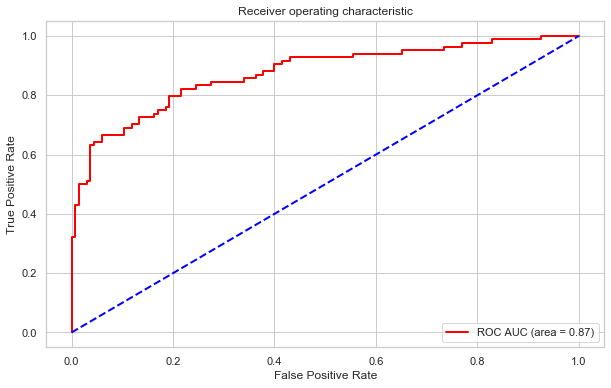

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Precision Recall curve

In [32]:
y_score = classifier.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)

precision_recall_df = pd.DataFrame([precision[0:len(threshold)],recall[0:len(threshold)],threshold]).T
precision_recall_df.columns = ['precision','recall','threshold']
precision_recall_df.head(6)

,precision,recall,threshold
0,0.401914,1.000000,-2.183269
1,0.399038,0.988095,-2.155041
2,0.400966,0.988095,-2.135124
3,0.402913,0.988095,-2.130919
4,0.404878,0.988095,-2.115777
5,0.406863,0.988095,-2.114993


Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.86')

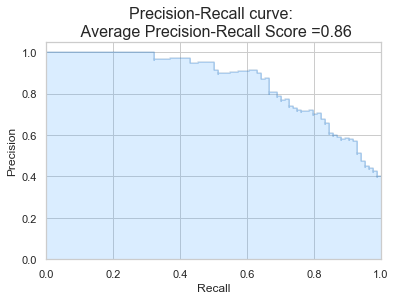

In [33]:
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

#### Precision Recall tradeoff

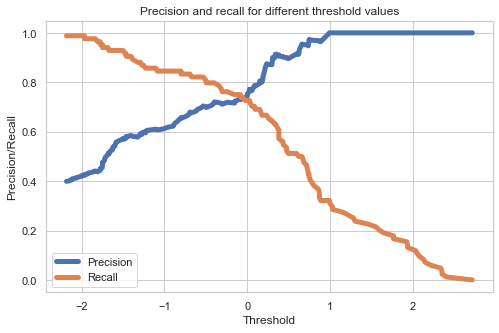

In [34]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## 10.2 - Random Forest
<a id="random_forest"></a>

### 10.2.1 Training model

#### Train - Test split

In [35]:
classifier = RandomForestClassifier(n_estimators=200)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Cross validation

In [36]:
cv_classifier = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

### 10.2.2 Predict & Evaluation

In [37]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

In [38]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.9832572298325722
0.7945205479452054
0.793123543123543 0.05484479950211831


In [39]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.9832572298325722
ROC AUC Score:  0.9974230844601214
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       405
           1       0.98      0.97      0.98       252

    accuracy                           0.98       657
   macro avg       0.98      0.98      0.98       657
weighted avg       0.98      0.98      0.98       657

-----------------------------------------------------------
Test set
Accuracy:  0.7899543378995434
ROC AUC Score:  0.8497795414462082
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       135
           1       0.74      0.70      0.72        84

    accuracy                           0.79       219
   macro avg       0.78      0.77      0.78       219
weighted avg       0.79      0.79      0.79       219



### 10.2.3 Tuning hyper parameters

#### Apply RandomizedSearchCV

In [40]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=100, stop = 2000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_sample_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators' : n_estimators,
               'max_features' : max_features,
               'max_depth' : max_depth,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf': min_sample_leaf,
               'bootstrap' : bootstrap
              }

In [41]:
grid_clf = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid, n_iter = 100, cv=5, error_score= np.nan, 
                               verbose=2, random_state=42, n_jobs = -1)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.7min finished


{'n_estimators': 900,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

#### Apply Grid search

In [93]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap' : [True],
    'max_depth' : [8, 10, 12, 14],
    'max_features' : ['sqrt'],
    'min_samples_leaf' : [1, 3, 4],
    'min_samples_split' : [7, 10, 12],
    'n_estimators' : [250, 275, 300, 325]
}

In [94]:
grid_clf = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid, n_iter = 100, cv=5, error_score= np.nan, 
                               verbose=2, random_state=42, n_jobs = -1)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.3s finished


{'n_estimators': 325,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

#### Re-run model with the best parameters

In [42]:
classifier = grid_clf.best_estimator_
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
cv_classifier = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

### 10.2.4 Predicting

In [44]:
prob_train_pred = classifier.predict_proba(X_train)
prob_test_pred = classifier.predict_proba(X_test)
prob_test_pred[0:5]

array([[0.74362747, 0.25637253],
       [0.53397835, 0.46602165],
       [0.6038164 , 0.3961836 ],
       [0.50976635, 0.49023365],
       [0.97828569, 0.02171431]])

In [45]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

In [46]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.9147640791476408
ROC AUC Score:  0.9779835390946502
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       405
           1       0.93      0.84      0.88       252

    accuracy                           0.91       657
   macro avg       0.92      0.90      0.91       657
weighted avg       0.92      0.91      0.91       657

-----------------------------------------------------------
Test set
Accuracy:  0.821917808219178
ROC AUC Score:  0.8725749559082893
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       135
           1       0.78      0.74      0.76        84

    accuracy                           0.82       219
   macro avg       0.81      0.81      0.81       219
weighted avg       0.82      0.82      0.82       219



### 10.2.5 Evaluating model

#### Summary

In [47]:
result_summary = pd.DataFrame(columns= ['Dataset',"accuracy", "roc_auc_score", "recall", "precision"] )
result_summary.loc[0,:] = ['Train',accuracy_score(y_train, y_train_pred), roc_auc_score(y_train, prob_train_pred[:,1]),recall_score(y_train, y_train_pred),precision_score(y_train, y_train_pred)]
result_summary.loc[1,:] = ['Test',accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, prob_test_pred[:,1]),recall_score(y_test, y_test_pred),precision_score(y_test, y_test_pred)]
result_summary

,Dataset,accuracy,roc_auc_score,recall,precision
0,Train,0.914764,0.977895,0.84127,0.929825
1,Test,0.821918,0.872663,0.738095,0.78481


#### Overal Accuracy

In [48]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.9147640791476408
0.821917808219178
0.8144055944055945 0.05782556717681804


In [49]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.915 , Test: 0.822, Validation: 0.814


#### Confusion Matrix

True         0    1
Predicted          
0          389   16
1           40  212


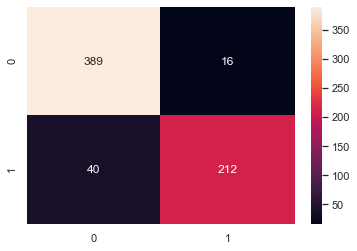

In [50]:
# Training set
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

Normalized confusion matrix
[[0.96049383 0.03950617]
 [0.15873016 0.84126984]]


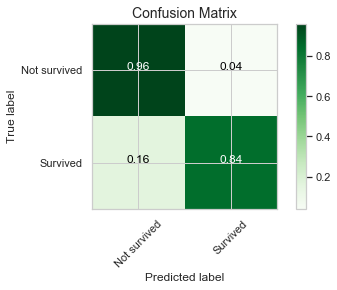

In [51]:
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=True)

True         0   1
Predicted         
0          118  17
1           22  62


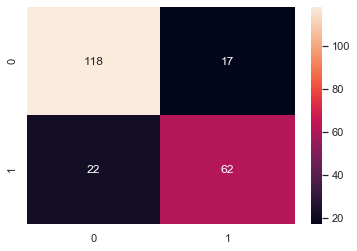

In [52]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

Normalized confusion matrix
[[0.87407407 0.12592593]
 [0.26190476 0.73809524]]


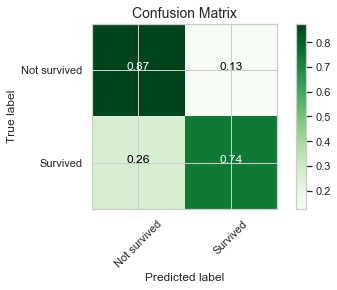

In [53]:
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=True)

#### Classification report

In [54]:
# Train
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       405
           1       0.93      0.84      0.88       252

    accuracy                           0.91       657
   macro avg       0.92      0.90      0.91       657
weighted avg       0.92      0.91      0.91       657



In [55]:
# Test
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       135
           1       0.78      0.74      0.76        84

    accuracy                           0.82       219
   macro avg       0.81      0.81      0.81       219
weighted avg       0.82      0.82      0.82       219



#### ROC AUC Score

In [56]:
# On train set
print(roc_auc_score(y_train, prob_train_pred[:,1]))
# On test set
roc_auc = roc_auc_score(y_test,prob_test_pred[:,1])
print(roc_auc)

0.9778953556731335
0.872663139329806


In [57]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

rocauc_df = pd.DataFrame([fpr,tpr,thresholds]).T
rocauc_df.columns = ['fpr','tpr','thresholds']
rocauc_df.head(8)

,fpr,tpr,thresholds
0,0.000000,0.000000,1.991408
1,0.000000,0.011905,0.991408
2,0.000000,0.154762,0.942638
3,0.007407,0.154762,0.942267
4,0.007407,0.380952,0.862785
5,0.014815,0.380952,0.860716
6,0.014815,0.500000,0.791309
7,0.022222,0.500000,0.782635


#### ROC Curve

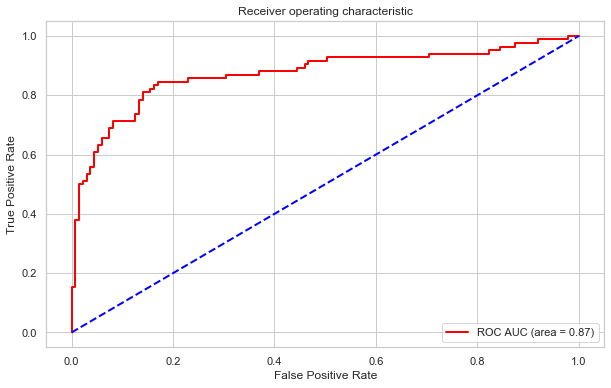

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Precision Recall curve

#### Precision Recall tradeoff

### 10.2.6 Model Interpretation

#### Important Features

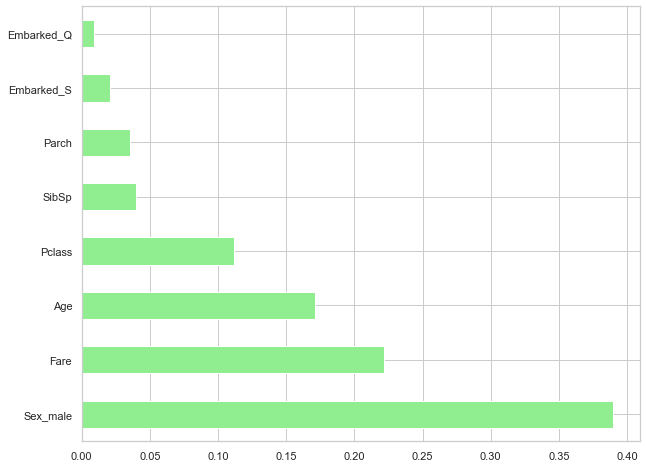

In [59]:
ax = (pd.Series(classifier.feature_importances_, index=X.columns)
   .nlargest(20)
   .plot(kind='barh', figsize=(10,8), color='lightgreen'))
plt.show()

## 10.3 - LightGBM
<a id="lightGBM"></a>

### 10.3.1 Train model

#### Train - Test split

In [60]:
classifier = LGBMClassifier()
classifier.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### K-Fold Cross Validation

In [61]:
kfold = KFold(n_splits = 10, random_state = 10)
cv_classifier = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = kfold)

In [62]:
cv_classifier

array([0.87878788, 0.81818182, 0.87878788, 0.78787879, 0.87878788,
       0.77272727, 0.72727273, 0.81538462, 0.78461538, 0.90769231])

In [63]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*cv_classifier.mean(), 100*cv_classifier.std() * 2))

Accuracy: 82.50% (+/- 11.13%)


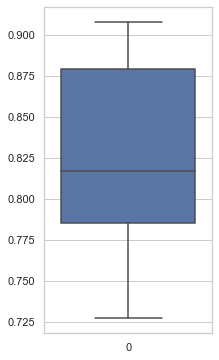

In [64]:
plt.figure(figsize=(3,6))
sns.boxplot(data=cv_classifier)
plt.show()

### 10.3.2 Prediction & Validation

In [65]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.9452054794520548
ROC AUC Score:  0.9897511267881638
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       405
           1       0.95      0.90      0.93       252

    accuracy                           0.95       657
   macro avg       0.95      0.94      0.94       657
weighted avg       0.95      0.95      0.94       657

-----------------------------------------------------------
Test set
Accuracy:  0.821917808219178
ROC AUC Score:  0.8534832451499118
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       135
           1       0.78      0.75      0.76        84

    accuracy                           0.82       219
   macro avg       0.81      0.81      0.81       219
weighted avg       0.82      0.82      0.82       219



### 10.3.3 Tuning hyper parameters

#### Apply grid search

In [66]:
params = {'C': [0.01,0.1,1,10,100,1000]}
grid_clf = GridSearchCV(LogisticRegression(), params, refit=True, scoring = 'accuracy', cv = 10, verbose = 2)

#### KFold Cross Validation

In [67]:
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.3s finished


{'C': 0.1}

#### Re-run with the best parameters

In [68]:
classifier = grid_clf.best_estimator_
classifier.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
cv_classifier = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

### 10.3.4 Predicting

In [70]:
prob_train_pred = classifier.predict_proba(X_train)
prob_test_pred = classifier.predict_proba(X_test)
prob_test_pred[0:5]

array([[0.47780643, 0.52219357],
       [0.43662335, 0.56337665],
       [0.34068021, 0.65931979],
       [0.38351402, 0.61648598],
       [0.79977754, 0.20022246]])

In [71]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

In [72]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.8036529680365296
ROC AUC Score:  0.8520968058005094
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       405
           1       0.78      0.68      0.73       252

    accuracy                           0.80       657
   macro avg       0.80      0.78      0.79       657
weighted avg       0.80      0.80      0.80       657

-----------------------------------------------------------
Test set
Accuracy:  0.7945205479452054
ROC AUC Score:  0.8744268077601411
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       135
           1       0.73      0.73      0.73        84

    accuracy                           0.79       219
   macro avg       0.78      0.78      0.78       219
weighted avg       0.79      0.79      0.79       219



### 10.3.5 Evaluating model

#### Summary

In [73]:
result_summary = pd.DataFrame(columns= ['Dataset',"accuracy", "roc_auc_score", "recall", "precision"] )
result_summary.loc[0,:] = ['Train',accuracy_score(y_train, y_train_pred), roc_auc_score(y_train, prob_train_pred[:,1]),recall_score(y_train, y_train_pred),precision_score(y_train, y_train_pred)]
result_summary.loc[1,:] = ['Test',accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, prob_test_pred[:,1]),recall_score(y_test, y_test_pred),precision_score(y_test, y_test_pred)]
result_summary

,Dataset,accuracy,roc_auc_score,recall,precision
0,Train,0.803653,0.852097,0.678571,0.780822
1,Test,0.794521,0.874427,0.72619,0.73494


#### Overall Accuracy

In [74]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.8036529680365296
0.7945205479452054
0.7959440559440558 0.06878567887418796


In [75]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.804 , Test: 0.795, Validation: 0.796


#### Confusion Matrix

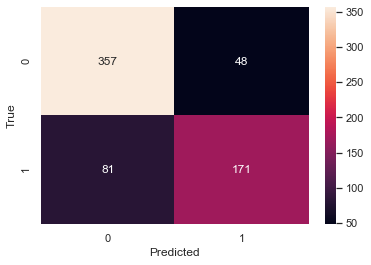

In [76]:
# Training set
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[357  48]
 [ 81 171]]


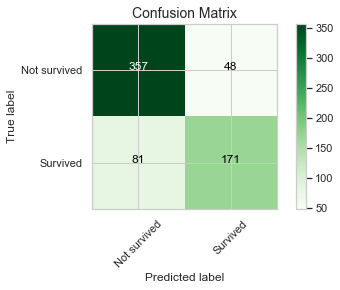

In [77]:
cm = confusion_matrix(y_train, y_train_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

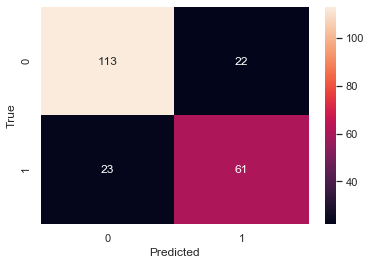

In [78]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[113  22]
 [ 23  61]]


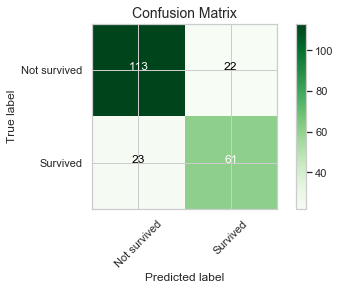

In [79]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

#### Classification Report

In [80]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       405
           1       0.78      0.68      0.73       252

    accuracy                           0.80       657
   macro avg       0.80      0.78      0.79       657
weighted avg       0.80      0.80      0.80       657



In [81]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       135
           1       0.73      0.73      0.73        84

    accuracy                           0.79       219
   macro avg       0.78      0.78      0.78       219
weighted avg       0.79      0.79      0.79       219



#### ROC AUC Score

In [82]:
# On train set
print(roc_auc_score(y_train, prob_train_pred[:,1]))
# On test set
roc_auc = roc_auc_score(y_test,prob_test_pred[:,1])
print(roc_auc)

0.8520968058005094
0.8744268077601411


In [83]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

rocauc_df = pd.DataFrame([fpr,tpr,thresholds]).T
rocauc_df.columns = ['fpr','tpr','thresholds']
rocauc_df.head(6)

,fpr,tpr,thresholds
0,0.000000,0.000000,1.938090
1,0.000000,0.011905,0.938090
2,0.000000,0.321429,0.730704
3,0.007407,0.321429,0.729750
4,0.007407,0.428571,0.678624
5,0.014815,0.428571,0.678410


#### ROC Curve

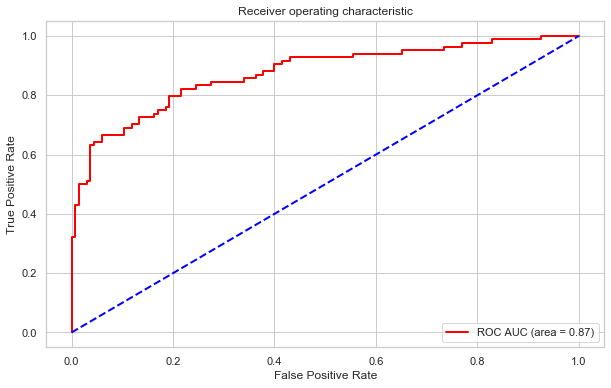

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

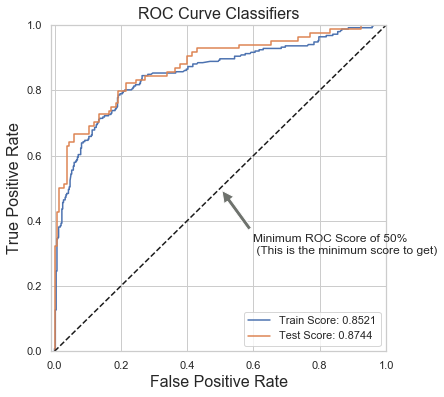

In [85]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()

#### Precision Recal curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.86')

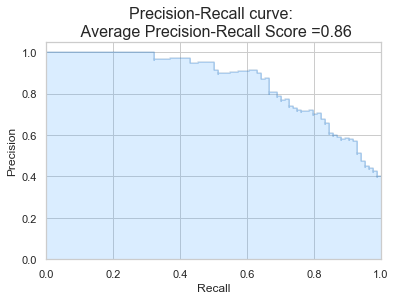

In [86]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_test_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.86')

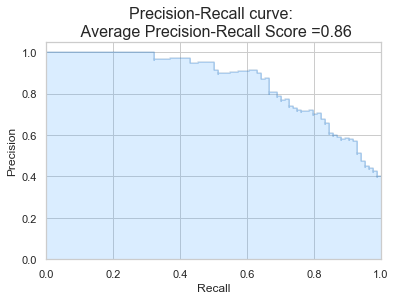

In [87]:
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

#### Precision Recall tradeoff

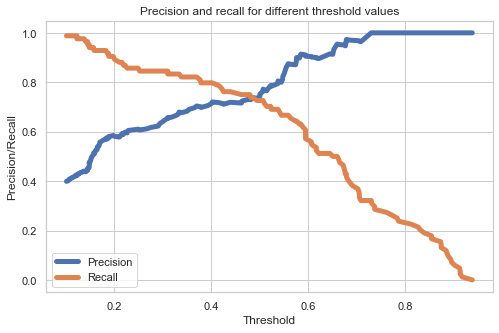

In [88]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## 10.4 - GradientBoostingTree
<a id="gradient_boosting"></a>

### 10.4.1 Train model

#### Train - Test split

In [89]:
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)
# default parameters
classifier.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### K-Fold Cross Validation

In [90]:
kfold = KFold(n_splits = 10, random_state = 10)
cv_classifier = cross_val_score(GradientBoostingClassifier(),X_train,y_train,cv=kfold,scoring='accuracy')
cv_classifier

array([0.81818182, 0.83333333, 0.87878788, 0.77272727, 0.86363636,
       0.8030303 , 0.74242424, 0.76923077, 0.8       , 0.89230769])

In [91]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*cv_classifier.mean(), 100*cv_classifier.std() * 2))

Accuracy: 81.74% (+/- 9.43%)


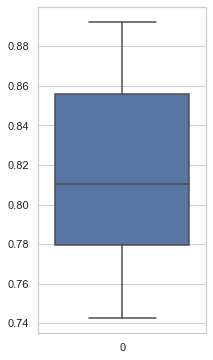

In [92]:
plt.figure(figsize=(3,6))
sns.boxplot(data=cv_classifier)
plt.show()

#### 10.4.2 Prediction & Evaluation

In [93]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.898021308980213
ROC AUC Score:  0.951244366059181
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       405
           1       0.91      0.81      0.86       252

    accuracy                           0.90       657
   macro avg       0.90      0.88      0.89       657
weighted avg       0.90      0.90      0.90       657

-----------------------------------------------------------
Test set
Accuracy:  0.8538812785388128
ROC AUC Score:  0.8828042328042329
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       135
           1       0.84      0.76      0.80        84

    accuracy                           0.85       219
   macro avg       0.85      0.84      0.84       219
weighted avg       0.85      0.85      0.85       219



### 10.4.3 Tuning hyper parameters

#### learning rate

In [94]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(learning_rate = learning_rate,random_state = 42)
    classifier.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(classifier.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.861
Accuracy score (validation): 0.858

Learning rate:  0.1
Accuracy score (training): 0.898
Accuracy score (validation): 0.854

Learning rate:  0.25
Accuracy score (training): 0.942
Accuracy score (validation): 0.854

Learning rate:  0.5
Accuracy score (training): 0.974
Accuracy score (validation): 0.840

Learning rate:  0.75
Accuracy score (training): 0.983
Accuracy score (validation): 0.799

Learning rate:  1
Accuracy score (training): 0.983
Accuracy score (validation): 0.808



#### Apply Grid search

In [95]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap' : [True],
    'max_depth' : [8, 10, 12, 14],
    'max_features' : ['sqrt'],
    'min_samples_leaf' : [1, 3, 4],
    'min_samples_split' : [7, 10, 12],
    'n_estimators' : [250, 275, 300, 325]
}
grid_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, refit=True, scoring = 'accuracy', cv = 10, verbose = 2)

#### KFold Cross Validation

In [96]:
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=250 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Invalid parameter bootstrap for estimator GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

#### Re-run with the best parameters

In [97]:
classifier = grid_clf.best_estimator_
classifier.fit(X_train, y_train)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [98]:
cv_classifier = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

### 10.4.4 Predicting

In [99]:
prob_train_pred = classifier.predict_proba(X_train)
prob_test_pred = classifier.predict_proba(X_test)
prob_test_pred[0:5]

array([[9.89250248e-01, 1.07497525e-02],
       [7.02935626e-01, 2.97064374e-01],
       [9.99449165e-01, 5.50835305e-04],
       [7.49438115e-01, 2.50561885e-01],
       [9.99427296e-01, 5.72704145e-04]])

In [100]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

In [101]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.9832572298325722
ROC AUC Score:  0.9992259455222419
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       405
           1       0.98      0.98      0.98       252

    accuracy                           0.98       657
   macro avg       0.98      0.98      0.98       657
weighted avg       0.98      0.98      0.98       657

-----------------------------------------------------------
Test set
Accuracy:  0.8082191780821918
ROC AUC Score:  0.8527336860670194
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       135
           1       0.76      0.74      0.75        84

    accuracy                           0.81       219
   macro avg       0.80      0.79      0.80       219
weighted avg       0.81      0.81      0.81       219



### 10.4.5 Evaluating model

#### Summary

In [102]:
result_summary = pd.DataFrame(columns= ['Dataset',"accuracy", "roc_auc_score", "recall", "precision"] )
result_summary.loc[0,:] = ['Train',accuracy_score(y_train, y_train_pred), roc_auc_score(y_train, prob_train_pred[:,1]),recall_score(y_train, y_train_pred),precision_score(y_train, y_train_pred)]
result_summary.loc[1,:] = ['Test',accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, prob_test_pred[:,1]),recall_score(y_test, y_test_pred),precision_score(y_test, y_test_pred)]
result_summary

,Dataset,accuracy,roc_auc_score,recall,precision
0,Train,0.983257,0.999226,0.97619,0.98008
1,Test,0.808219,0.852734,0.738095,0.756098


#### Overall Accuracy

In [103]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.9832572298325722
0.8082191780821918
0.7855011655011654 0.039304985014368715


In [104]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.983 , Test: 0.808, Validation: 0.786


#### Confusion Matrix

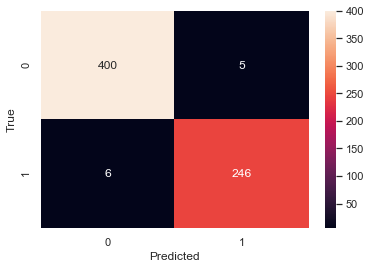

In [105]:
# Training set
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[113  22]
 [ 23  61]]


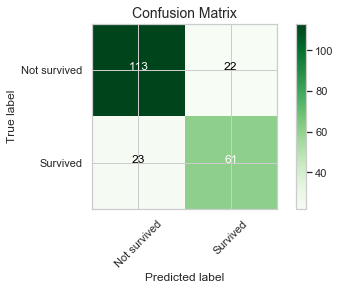

In [106]:
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

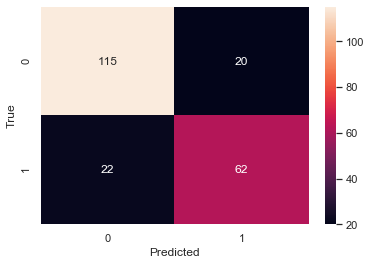

In [107]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[113  22]
 [ 23  61]]


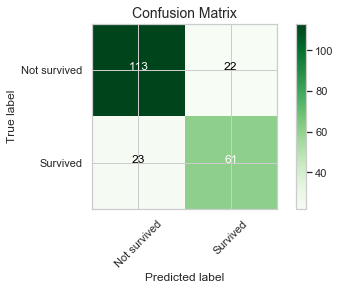

In [108]:
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

#### Classification Report

In [109]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       405
           1       0.98      0.98      0.98       252

    accuracy                           0.98       657
   macro avg       0.98      0.98      0.98       657
weighted avg       0.98      0.98      0.98       657



In [110]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       135
           1       0.76      0.74      0.75        84

    accuracy                           0.81       219
   macro avg       0.80      0.79      0.80       219
weighted avg       0.81      0.81      0.81       219



#### ROC AUC Score

In [111]:
# On train set
print(roc_auc_score(y_train, prob_train_pred[:,1]))
# On test set
roc_auc = roc_auc_score(y_test,prob_test_pred[:,1])
print(roc_auc)

0.9992259455222419
0.8527336860670194


In [112]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

rocauc_df = pd.DataFrame([fpr,tpr,thresholds]).T
rocauc_df.columns = ['fpr','tpr','thresholds']
rocauc_df.head(6)

,fpr,tpr,thresholds
0,0.000000,0.000000,1.999996
1,0.000000,0.011905,0.999996
2,0.000000,0.202381,0.999306
3,0.007407,0.202381,0.999200
4,0.007407,0.285714,0.998291
5,0.014815,0.285714,0.998229


#### ROC Curve

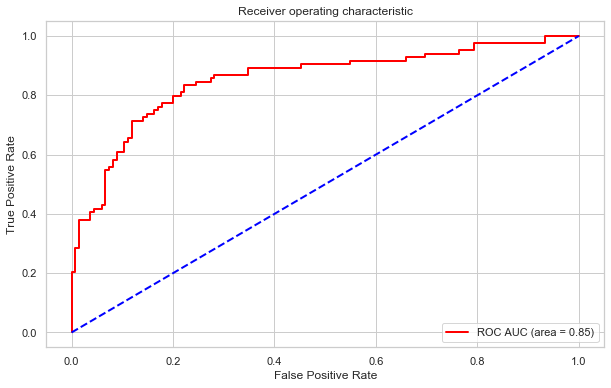

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

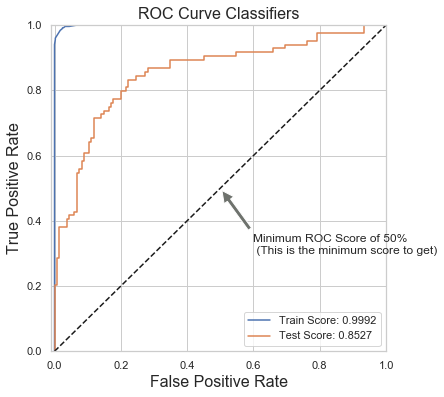

In [114]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


#### Precision Recall curve

In [115]:
y_score = classifier.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)

precision_recall_df = pd.DataFrame([precision[0:len(threshold)],recall[0:len(threshold)],threshold]).T
precision_recall_df.columns = ['precision','recall','threshold']
precision_recall_df.head(6)

,precision,recall,threshold
0,0.400000,1.000000,-10.115430
1,0.397129,0.988095,-9.940974
2,0.394231,0.976190,-9.867521
3,0.396135,0.976190,-9.771911
4,0.398058,0.976190,-9.693613
5,0.400000,0.976190,-9.357858


Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.82')

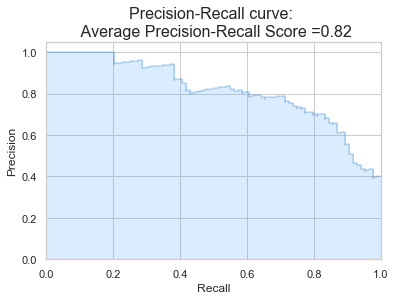

In [116]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score =  prob_test_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.82')

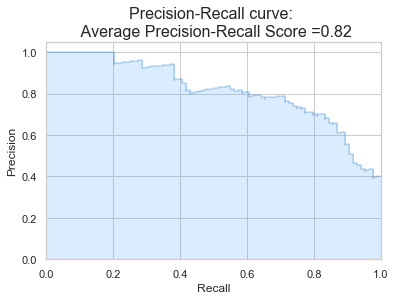

In [117]:
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

#### Precision Recall tradeoff

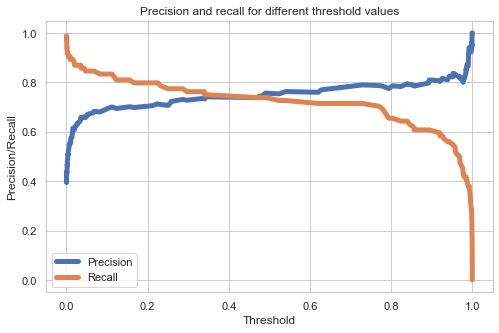

In [118]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =1.00')

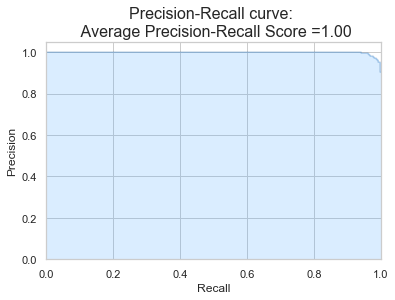

In [119]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_train_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

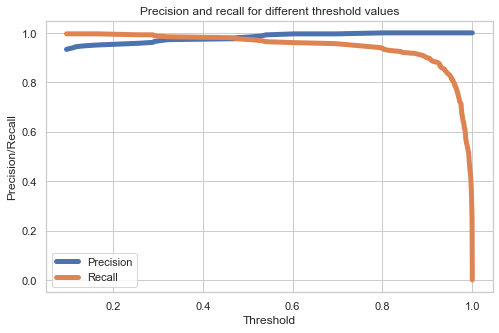

In [120]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## 10.5 - AdaBoost
<a id="adaboost"></a>

### 10.5.1 Train model

#### Train - Test split

In [121]:
classifier = AdaBoostClassifier()
classifier.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

#### K-Fold Cross Validation

In [122]:
kfold = KFold(n_splits = 10, random_state = 10)
cv_classifier = cross_val_score(AdaBoostClassifier(),X_train,y_train,cv=kfold,scoring='accuracy')
cv_classifier

array([0.72727273, 0.83333333, 0.83333333, 0.8030303 , 0.81818182,
       0.77272727, 0.72727273, 0.73846154, 0.75384615, 0.87692308])

In [123]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*cv_classifier.mean(), 100*cv_classifier.std() * 2))

Accuracy: 78.84% (+/- 9.88%)


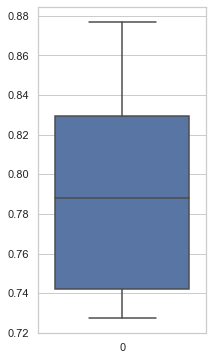

In [124]:
plt.figure(figsize=(3,6))
sns.boxplot(data=cv_classifier)
plt.show()

### 10.5.2 Prediction & Evaluation

In [125]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.8264840182648402
ROC AUC Score:  0.9002204585537918
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       405
           1       0.79      0.75      0.77       252

    accuracy                           0.83       657
   macro avg       0.82      0.81      0.81       657
weighted avg       0.83      0.83      0.83       657

-----------------------------------------------------------
Test set
Accuracy:  0.8264840182648402
ROC AUC Score:  0.8675044091710759
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       135
           1       0.79      0.75      0.77        84

    accuracy                           0.83       219
   macro avg       0.82      0.81      0.81       219
weighted avg       0.83      0.83      0.83       219



### 10.5.3 Tuning hyper parameters

#### Apply Grid search

In [126]:
params = {'C': [0.01,0.1,1,10,100,1000]}
grid_clf = GridSearchCV(LogisticRegression(), params, refit=True, scoring = 'accuracy', cv = 10, verbose = 2)

#### KFold Cross Validation

In [127]:
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s finished


{'C': 0.1}

#### Re-run with the best parameters

In [128]:
classifier = grid_clf.best_estimator_
classifier.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [129]:
cv_classifier = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

### 10.5.4 Predicting

In [130]:
prob_train_pred = classifier.predict_proba(X_train)
prob_test_pred = classifier.predict_proba(X_test)
prob_test_pred[0:5]

array([[0.47780643, 0.52219357],
       [0.43662335, 0.56337665],
       [0.34068021, 0.65931979],
       [0.38351402, 0.61648598],
       [0.79977754, 0.20022246]])

In [131]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

### 10.5.5 Evaluating model

#### Summary

In [132]:
result_summary = pd.DataFrame(columns= ['Dataset',"accuracy", "roc_auc_score", "recall", "precision"] )
result_summary.loc[0,:] = ['Train',accuracy_score(y_train, y_train_pred), roc_auc_score(y_train, prob_train_pred[:,1]),recall_score(y_train, y_train_pred),precision_score(y_train, y_train_pred)]
result_summary.loc[1,:] = ['Test',accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, prob_test_pred[:,1]),recall_score(y_test, y_test_pred),precision_score(y_test, y_test_pred)]
result_summary

,Dataset,accuracy,roc_auc_score,recall,precision
0,Train,0.803653,0.852097,0.678571,0.780822
1,Test,0.794521,0.874427,0.72619,0.73494


#### Overall Accuracy

In [133]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.8036529680365296
0.7945205479452054
0.7959440559440558 0.06878567887418796


In [134]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.804 , Test: 0.795, Validation: 0.796


#### Confusion Matrix

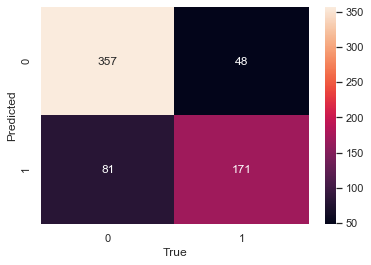

In [135]:
# Training set
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[357  48]
 [ 81 171]]


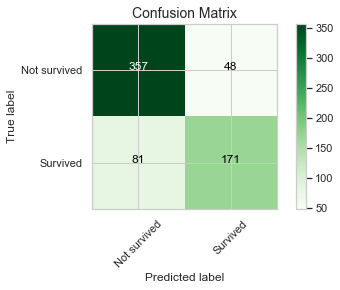

In [136]:
cm = confusion_matrix(y_train, y_train_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

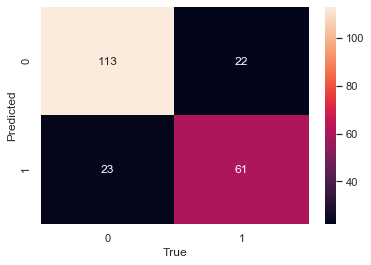

In [137]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[113  22]
 [ 23  61]]


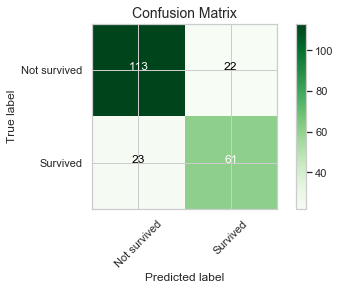

In [138]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

#### Classification Report

In [139]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       405
           1       0.78      0.68      0.73       252

    accuracy                           0.80       657
   macro avg       0.80      0.78      0.79       657
weighted avg       0.80      0.80      0.80       657



In [140]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       135
           1       0.73      0.73      0.73        84

    accuracy                           0.79       219
   macro avg       0.78      0.78      0.78       219
weighted avg       0.79      0.79      0.79       219



#### ROC AUC Score

In [141]:
# On train set
print(roc_auc_score(y_train, prob_train_pred[:,1]))
# On test set
roc_auc = roc_auc_score(y_test,prob_test_pred[:,1])
print(roc_auc)

0.8520968058005094
0.8744268077601411


In [142]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

rocauc_df = pd.DataFrame([fpr,tpr,thresholds]).T
rocauc_df.columns = ['fpr','tpr','thresholds']
rocauc_df.head(6)

,fpr,tpr,thresholds
0,0.000000,0.000000,1.938090
1,0.000000,0.011905,0.938090
2,0.000000,0.321429,0.730704
3,0.007407,0.321429,0.729750
4,0.007407,0.428571,0.678624
5,0.014815,0.428571,0.678410


#### ROC Curve

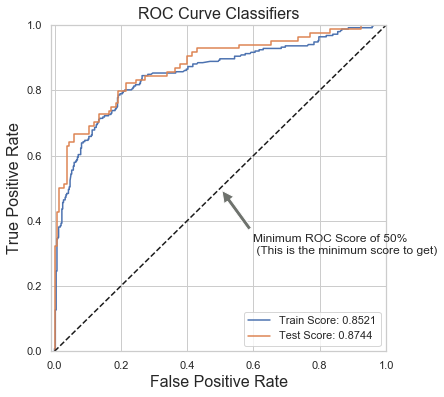

In [143]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


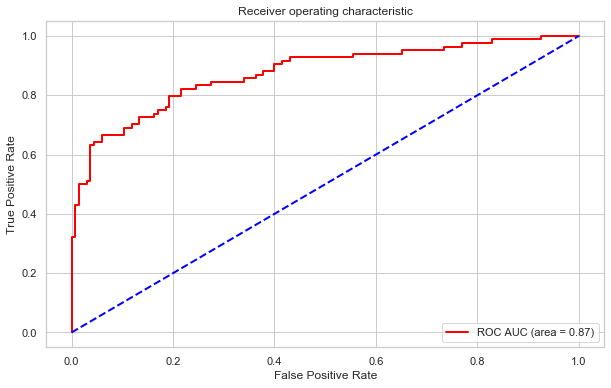

In [144]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Precision Recall curve

In [145]:
y_score = classifier.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)

precision_recall_df = pd.DataFrame([precision[0:len(threshold)],recall[0:len(threshold)],threshold]).T
precision_recall_df.columns = ['precision','recall','threshold']
precision_recall_df.head(6)

,precision,recall,threshold
0,0.401914,1.000000,-2.183269
1,0.399038,0.988095,-2.155041
2,0.400966,0.988095,-2.135124
3,0.402913,0.988095,-2.130919
4,0.404878,0.988095,-2.115777
5,0.406863,0.988095,-2.114993


Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.86')

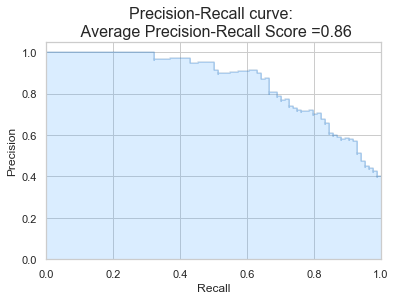

In [146]:
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

In [147]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

NameError: name 'model' is not defined

#### Precision Recall tradeoff

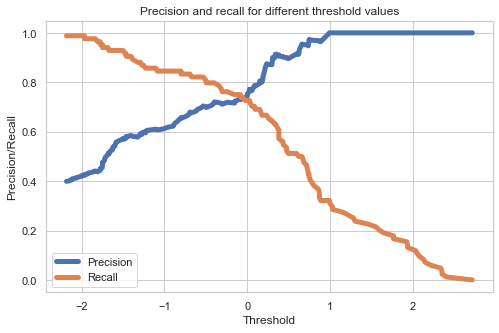

In [148]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [149]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_train)
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

NameError: name 'model' is not defined

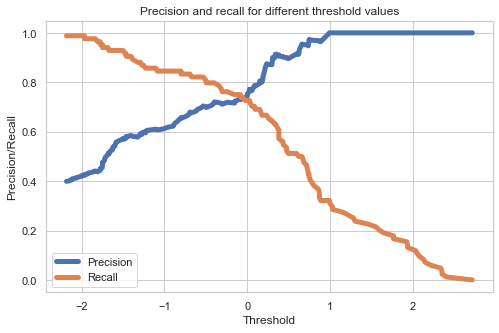

In [150]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## 10.6 - SVM
<a id="svm"></a>

### 10.6.1 Train model

#### Train - Test split

In [151]:
from sklearn.svm import SVC
classifier = SVC(probability=True)
classifier.fit(X_train, y_train)
# default parameters
model.get_params()

NameError: name 'model' is not defined

#### K-Fold Cross Validation

In [152]:
kfold = KFold(n_splits = 10, random_state = 10)
cv_classifier = cross_val_score(SVC(probability=True),X_train,y_train,cv=kfold,scoring='accuracy')
cv_classifier

array([0.78787879, 0.84848485, 0.89393939, 0.77272727, 0.77272727,
       0.83333333, 0.77272727, 0.78461538, 0.76923077, 0.89230769])

In [153]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*cv_classifier.mean(), 100*cv_classifier.std() * 2))

Accuracy: 81.28% (+/- 9.54%)


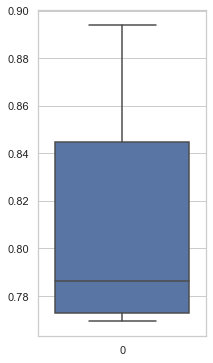

In [154]:
plt.figure(figsize=(3,6))
sns.boxplot(data=cv_classifier)
plt.show()

### 10.6.2 Prediction & Evaluation

In [155]:
prob_train_pred = classifier.predict_proba(X_train)
prob_test_pred = classifier.predict_proba(X_test)
prob_test_pred[0:5]

array([[0.22676516, 0.77323484],
       [0.2295898 , 0.7704102 ],
       [0.59089477, 0.40910523],
       [0.35672991, 0.64327009],
       [0.8382321 , 0.1617679 ]])

In [156]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

In [157]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'SVM')

Model Evaluation of SVM
-----------------------------------------------------------
Train set
Accuracy:  0.8340943683409436
ROC AUC Score:  0.8620419361160102
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       405
           1       0.81      0.73      0.77       252

    accuracy                           0.83       657
   macro avg       0.83      0.82      0.82       657
weighted avg       0.83      0.83      0.83       657

-----------------------------------------------------------
Test set
Accuracy:  0.8310502283105022
ROC AUC Score:  0.8807760141093475
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       135
           1       0.81      0.73      0.77        84

    accuracy                           0.83       219
   macro avg       0.83      0.81      0.82       219
weighted avg       0.83      0.83      0.83       219



### 10.6.3 Tuning hyper parameters

#### Apply Grid search

In [158]:
param_grid = {
    'C': [1.0, 10.0, 50.0],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'shrinking': [True, False],
    'gamma': ['auto', 1, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

grid_clf = GridSearchCV(SVC(), param_grid = params, scoring = 'accuracy', cv = 10, verbose = 2)

#### KFold Cross Validation

In [159]:
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    2.0s finished


{'C': 1}

#### Re-run model with the best parameters

In [160]:
classifier = grid_clf.best_estimator_
cv_classifier = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy').mean()

### 10.6.4 Prediction

In [161]:
prob_train_pred = classifier.predict_proba(X_train)
prob_test_pred = classifier.predict_proba(X_test)
prob_test_pred[0:5]

AttributeError: predict_proba is not available when  probability=False

In [162]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

### 10.6.5 Model Evaluation

#### Summary

In [163]:
result_summary = pd.DataFrame(columns= ['Dataset',"accuracy", "roc_auc_score", "recall", "precision"] )
result_summary.loc[0,:] = ['Train',accuracy_score(y_train, y_train_pred), roc_auc_score(y_train, prob_train_pred[:,1]),recall_score(y_train, y_train_pred),precision_score(y_train, y_train_pred)]
result_summary.loc[1,:] = ['Test',accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, prob_test_pred[:,1]),recall_score(y_test, y_test_pred),precision_score(y_test, y_test_pred)]
result_summary

,Dataset,accuracy,roc_auc_score,recall,precision
0,Train,0.834094,0.862047,0.734127,0.814978
1,Test,0.83105,0.880776,0.72619,0.813333


#### Overall Accuracy

In [164]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.8340943683409436
0.8310502283105022
0.8127738927738927 0.0


In [165]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.834 , Test: 0.831, Validation: 0.813


#### Confusion Matrix

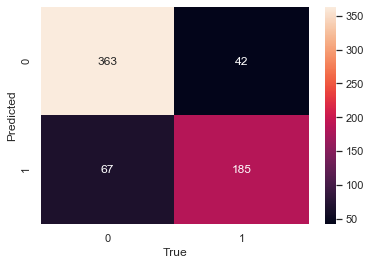

In [166]:
# Training set
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[363  42]
 [ 67 185]]


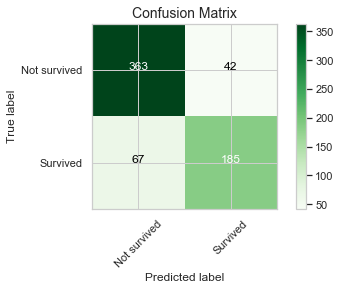

In [167]:
cm = confusion_matrix(y_train, y_train_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

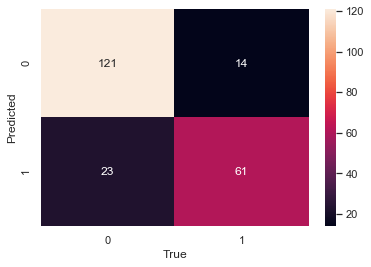

In [168]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[121  14]
 [ 23  61]]


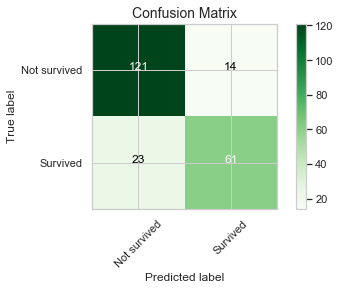

In [169]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

#### Classification Report

In [170]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       405
           1       0.81      0.73      0.77       252

    accuracy                           0.83       657
   macro avg       0.83      0.82      0.82       657
weighted avg       0.83      0.83      0.83       657



In [171]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       135
           1       0.81      0.73      0.77        84

    accuracy                           0.83       219
   macro avg       0.83      0.81      0.82       219
weighted avg       0.83      0.83      0.83       219



#### ROC AUC Score

In [172]:
# On train set
print(roc_auc_score(y_train, prob_train_pred[:,1]))
# On test set
roc_auc = roc_auc_score(y_test,prob_test_pred[:,1])
print(roc_auc)

0.8620468351949833
0.8807760141093475


In [173]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

rocauc_df = pd.DataFrame([fpr,tpr,thresholds]).T
rocauc_df.columns = ['fpr','tpr','thresholds']
rocauc_df.head(8)

AttributeError: predict_proba is not available when  probability=False

#### ROC Curve

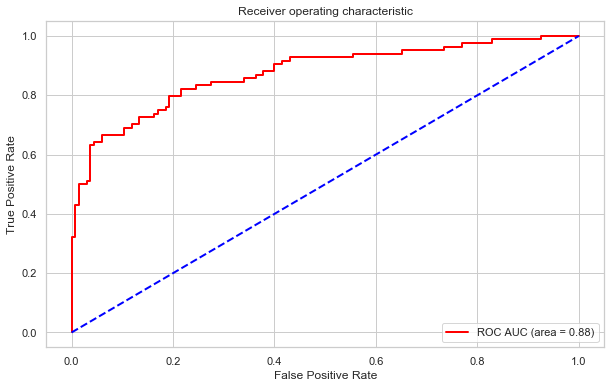

In [174]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

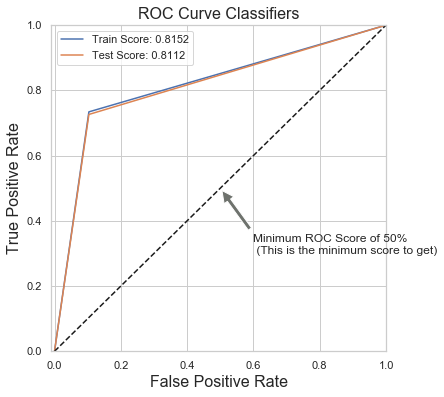

In [175]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, threshold = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, y_train_pred)))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, y_test_pred)))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


#### Precision Recall curve

In [176]:
y_score = classifier.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)

precision_recall_df = pd.DataFrame([precision[0:len(threshold)],recall[0:len(threshold)],threshold]).T
precision_recall_df.columns = ['precision','recall','threshold']
precision_recall_df.head(6)

,precision,recall,threshold
0,0.405797,1.000000,-1.121954
1,0.402913,0.988095,-1.108505
2,0.404878,0.988095,-1.087429
3,0.406863,0.988095,-1.087346
4,0.408867,0.988095,-1.076303
5,0.410891,0.988095,-1.070382


Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.86')

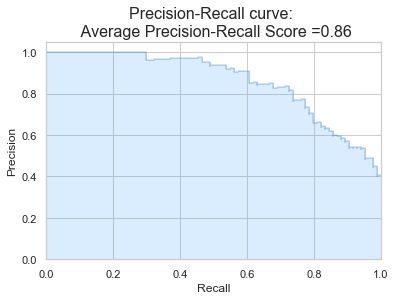

In [177]:
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

In [178]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

NameError: name 'model' is not defined

#### Precision Recall tradeoff 

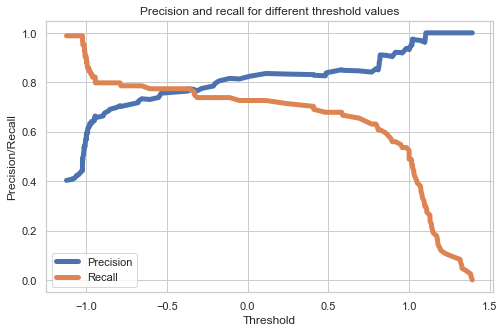

In [179]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

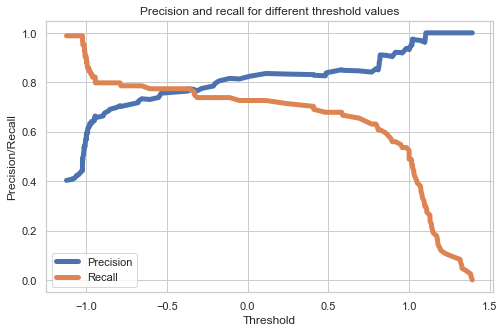

In [180]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [181]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_train)
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

NameError: name 'model' is not defined

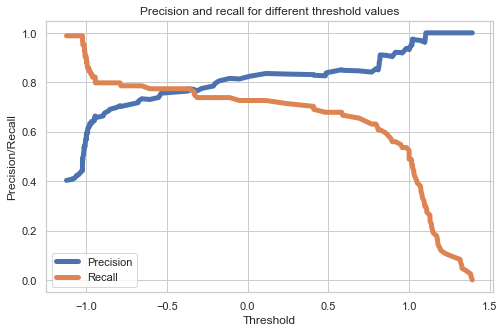

In [182]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## 10.7 - GaussianNB
<a id="guassianNB"></a>

### 10.7.1 Train model

#### Train - Test split

In [183]:
from sklearn.naive_bayes import GaussianNB 
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

#### K-Fold Cross Validation

In [184]:
kfold = KFold(n_splits = 10, random_state = 10)
cv_classifier = cross_val_score(GaussianNB(),X_train,y_train,cv=kfold,scoring='accuracy')
cv_classifier

array([0.75757576, 0.78787879, 0.84848485, 0.83333333, 0.78787879,
       0.75757576, 0.68181818, 0.76923077, 0.72307692, 0.86153846])

In [185]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*cv_classifier.mean(), 100*cv_classifier.std() * 2))

Accuracy: 78.08% (+/- 10.64%)


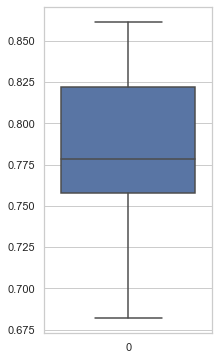

In [186]:
plt.figure(figsize=(3,6))
sns.boxplot(data=cv_classifier)
plt.show()

### 10.7.2 Predictioin & Evaluation

In [187]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.7899543378995434
ROC AUC Score:  0.8320791691162062
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       405
           1       0.74      0.71      0.72       252

    accuracy                           0.79       657
   macro avg       0.78      0.77      0.78       657
weighted avg       0.79      0.79      0.79       657

-----------------------------------------------------------
Test set
Accuracy:  0.8127853881278538
ROC AUC Score:  0.8618165784832452
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       135
           1       0.77      0.74      0.75        84

    accuracy                           0.81       219
   macro avg       0.80      0.80      0.80       219
weighted avg       0.81      0.81      0.81       219



### 10.7.3 Tuning hyper parameters

#### Apply Grid search

#### KFold Cross Validation

#### Re-run with the best parameters

### 10.7.4 Prediction

In [188]:
prob_train_pred = classifier.predict_proba(X_train)
prob_test_pred = classifier.predict_proba(X_test)
prob_test_pred[0:5]

array([[4.33559218e-01, 5.66440782e-01],
       [3.67317468e-01, 6.32682532e-01],
       [2.49453438e-07, 9.99999751e-01],
       [3.37595142e-02, 9.66240486e-01],
       [9.12204615e-01, 8.77953848e-02]])

In [189]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

In [190]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.7899543378995434
ROC AUC Score:  0.8320791691162062
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       405
           1       0.74      0.71      0.72       252

    accuracy                           0.79       657
   macro avg       0.78      0.77      0.78       657
weighted avg       0.79      0.79      0.79       657

-----------------------------------------------------------
Test set
Accuracy:  0.8127853881278538
ROC AUC Score:  0.8618165784832452
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       135
           1       0.77      0.74      0.75        84

    accuracy                           0.81       219
   macro avg       0.80      0.80      0.80       219
weighted avg       0.81      0.81      0.81       219



### 10.7.5 Evaluating model

#### Summary

In [191]:
result_summary = pd.DataFrame(columns= ['Dataset',"accuracy", "roc_auc_score", "recall", "precision"] )
result_summary.loc[0,:] = ['Train',accuracy_score(y_train, y_train_pred), roc_auc_score(y_train, prob_train_pred[:,1]),recall_score(y_train, y_train_pred),precision_score(y_train, y_train_pred)]
result_summary.loc[1,:] = ['Test',accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, prob_test_pred[:,1]),recall_score(y_test, y_test_pred),precision_score(y_test, y_test_pred)]
result_summary

,Dataset,accuracy,roc_auc_score,recall,precision
0,Train,0.789954,0.832079,0.706349,0.735537
1,Test,0.812785,0.861817,0.738095,0.765432


#### Overall Accuracy

In [192]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.7899543378995434
0.8127853881278538
0.7808391608391609 0.05319945869092638


In [193]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.790 , Test: 0.813, Validation: 0.781


#### Confusion Matrix

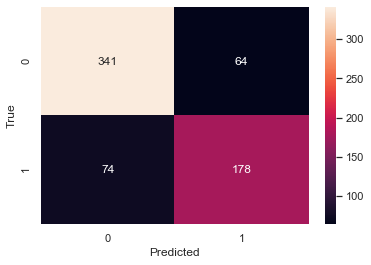

In [194]:
# Training set
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[341  64]
 [ 74 178]]


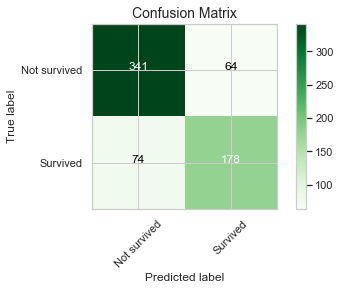

In [195]:
cm = confusion_matrix(y_train, y_train_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

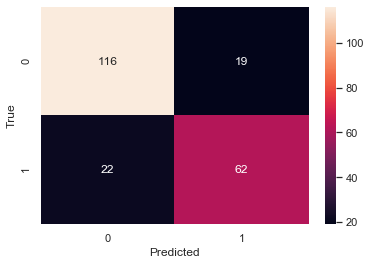

In [196]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[116  19]
 [ 22  62]]


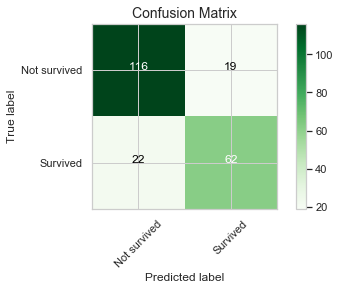

In [197]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

#### Classification Report

In [198]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       405
           1       0.74      0.71      0.72       252

    accuracy                           0.79       657
   macro avg       0.78      0.77      0.78       657
weighted avg       0.79      0.79      0.79       657



In [199]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       135
           1       0.77      0.74      0.75        84

    accuracy                           0.81       219
   macro avg       0.80      0.80      0.80       219
weighted avg       0.81      0.81      0.81       219



#### ROC AUC Score

In [200]:
# On train set
print(roc_auc_score(y_train, prob_train_pred[:,1]))
# On test set
roc_auc = roc_auc_score(y_test,prob_test_pred[:,1])
print(roc_auc)

0.8320791691162062
0.8618165784832452


In [201]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

rocauc_df = pd.DataFrame([fpr,tpr,thresholds]).T
rocauc_df.columns = ['fpr','tpr','thresholds']
rocauc_df.head(8)

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.000000,0.011905,1.000000
2,0.007407,0.011905,1.000000
3,0.007407,0.095238,0.996263
4,0.014815,0.095238,0.995140
5,0.014815,0.214286,0.966240
6,0.022222,0.214286,0.965535
7,0.022222,0.261905,0.944791


#### ROC Curve

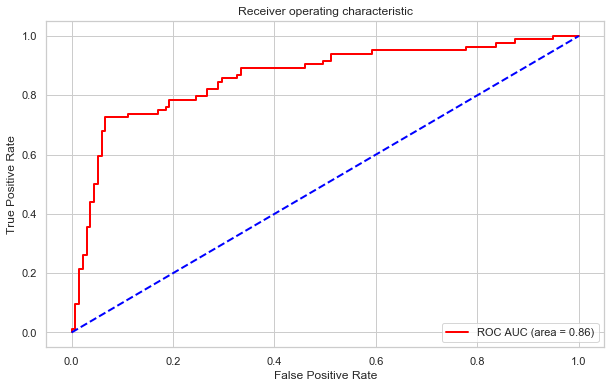

In [202]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

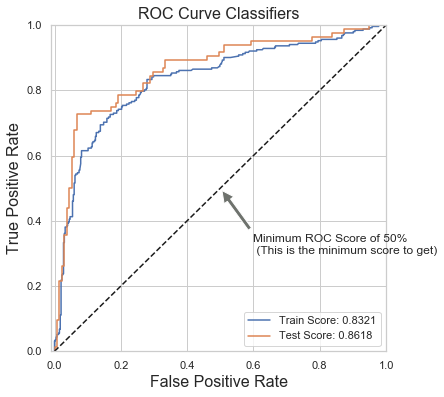

In [203]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


#### Precision Recall curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.79')

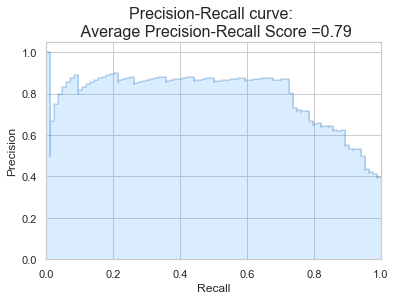

In [204]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_test_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

#### Precision Recall tradeoff

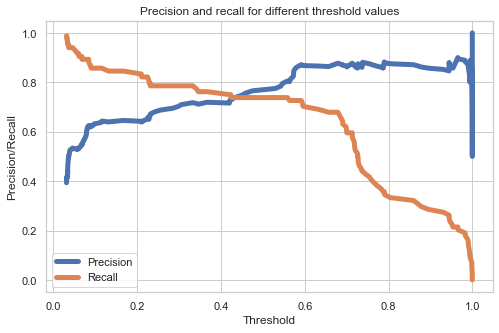

In [205]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.76')

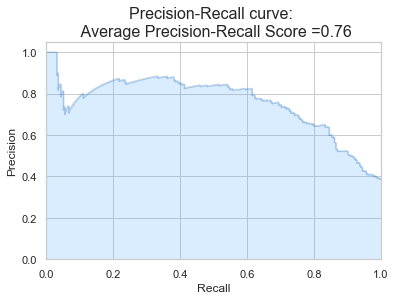

In [206]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_train_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

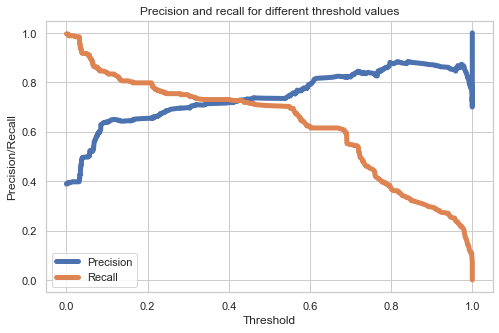

In [207]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## 10.8 - KNN
<a id="knn"></a>

### 10.8.1 Training model

In [208]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#### K-Fold Cross Validation

In [209]:
kfold = KFold(n_splits = 10, random_state = 10)
cv_classifier = cross_val_score(KNeighborsClassifier(),X_train,y_train,cv=kfold,scoring='accuracy')
cv_classifier

array([0.71212121, 0.83333333, 0.81818182, 0.71212121, 0.81818182,
       0.71212121, 0.6969697 , 0.8       , 0.73846154, 0.87692308])

In [210]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*cv_classifier.mean(), 100*cv_classifier.std() * 2))

Accuracy: 77.18% (+/- 12.22%)


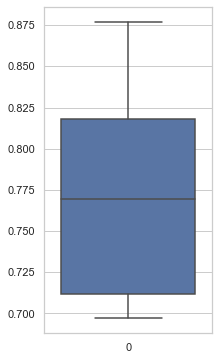

In [211]:
plt.figure(figsize=(3,6))
sns.boxplot(data=cv_classifier)
plt.show()

### 10.8.2 Predicting

In [212]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

In [213]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.837138508371385
ROC AUC Score:  0.9196844993141289
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       405
           1       0.81      0.75      0.78       252

    accuracy                           0.84       657
   macro avg       0.83      0.82      0.83       657
weighted avg       0.84      0.84      0.84       657

-----------------------------------------------------------
Test set
Accuracy:  0.817351598173516
ROC AUC Score:  0.8426366843033509
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       135
           1       0.75      0.79      0.77        84

    accuracy                           0.82       219
   macro avg       0.81      0.81      0.81       219
weighted avg       0.82      0.82      0.82       219



### 10.8.3 Tuning hyper parameters

In [214]:
from sklearn.neighbors import KNeighborsClassifier
error_rate =[]

for i in range (1,50):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(X_train,y_train)
    pred_i= classifier.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

#### Select k values

Text(0, 0.5, 'Error Rate')

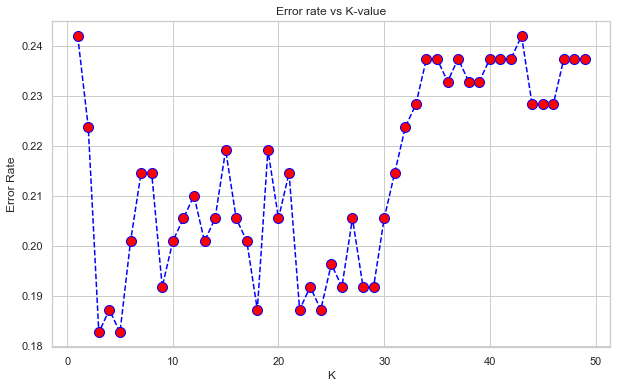

In [215]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error rate vs K-value')
plt.xlabel('K')
plt.ylabel('Error Rate')

#### select k = 9

In [216]:
classifier = KNeighborsClassifier(n_neighbors=9)
classifier.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [217]:
params = {"n_neighbors": list(range(2,8,1)), 'algorithm':['auto','ball_tree','kd_tree','brute']}
grid_search = GridSearchCV(KNeighborsClassifier(), params)
grid_search.fit(X_train, y_train)

# KNears best estimator
best_model = grid_search.best_estimator_
best_model

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [218]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 77.64% (+/- 14.20%)


In [219]:
scores

array([0.6969697 , 0.81818182, 0.86363636, 0.68181818, 0.8030303 ,
       0.75757576, 0.71212121, 0.8       , 0.72307692, 0.90769231])

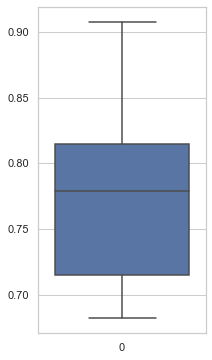

In [220]:
plt.figure(figsize=(3,6))
sns.boxplot(data=scores)
plt.show()

#### KFold Cross Validation

In [221]:
kfold = KFold(n_splits = 10, random_state = 10)
cv_classifier = cross_val_score(KNeighborsClassifier(n_neighbors=9),X_train,y_train,cv=kfold,scoring='accuracy')
cv_classifier

array([0.75757576, 0.87878788, 0.84848485, 0.6969697 , 0.75757576,
       0.6969697 , 0.6969697 , 0.8       , 0.73846154, 0.90769231])

In [222]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*cv_classifier.mean(), 100*cv_classifier.std() * 2))

Accuracy: 77.79% (+/- 14.77%)


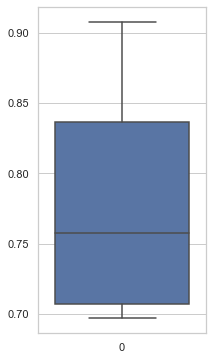

In [223]:
plt.figure(figsize=(3,6))
sns.boxplot(data=cv_classifier)
plt.show()

### 10.4 Predicting

In [224]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

### 10.5 Evaluating model

#### Summary

In [225]:
result_summary = pd.DataFrame(columns= ['Dataset',"accuracy", "roc_auc_score", "recall", "precision"] )
result_summary.loc[0,:] = ['Train',accuracy_score(y_train, y_train_pred), roc_auc_score(y_train, prob_train_pred[:,1]),recall_score(y_train, y_train_pred),precision_score(y_train, y_train_pred)]
result_summary.loc[1,:] = ['Test',accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, prob_test_pred[:,1]),recall_score(y_test, y_test_pred),precision_score(y_test, y_test_pred)]
result_summary

,Dataset,accuracy,roc_auc_score,recall,precision
0,Train,0.821918,0.832079,0.738095,0.78481
1,Test,0.808219,0.861817,0.761905,0.744186


#### Accuracy score

In [226]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.821917808219178
0.8082191780821918
0.7779487179487179 0.07384151818465381


In [227]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.822 , Test: 0.808, Validation: 0.778


#### Confusion matrix

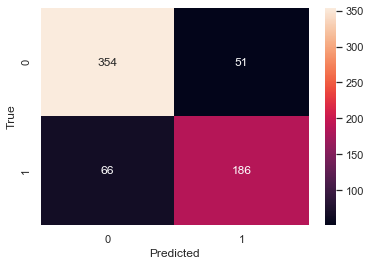

In [228]:
# Training set
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[354  51]
 [ 66 186]]


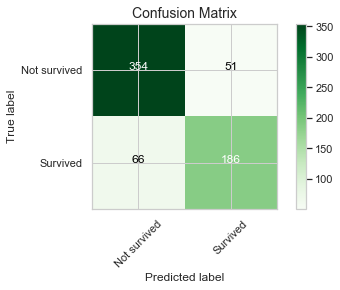

In [229]:
cm = confusion_matrix(y_train, y_train_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

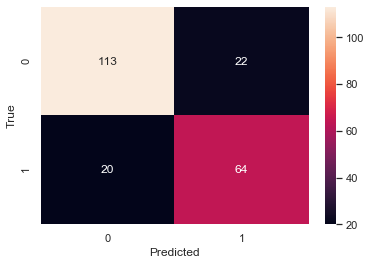

In [230]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Normalized confusion matrix
[[0.83703704 0.16296296]
 [0.23809524 0.76190476]]


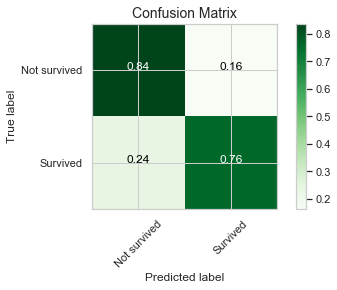

In [231]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=True)

#### Classification report

In [232]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       405
           1       0.78      0.74      0.76       252

    accuracy                           0.82       657
   macro avg       0.81      0.81      0.81       657
weighted avg       0.82      0.82      0.82       657



In [233]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       135
           1       0.74      0.76      0.75        84

    accuracy                           0.81       219
   macro avg       0.80      0.80      0.80       219
weighted avg       0.81      0.81      0.81       219



#### ROC AUC Score

In [234]:
# On train set
print(roc_auc_score(y_train, prob_train_pred[:,1]))
# On test set
roc_auc = roc_auc_score(y_test,prob_test_pred[:,1])
print(roc_auc)

0.8320791691162062
0.8618165784832452


In [235]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

rocauc_df = pd.DataFrame([fpr,tpr,thresholds]).T
rocauc_df.columns = ['fpr','tpr','thresholds']
rocauc_df.head(6)

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.014815,0.178571,1.000000
2,0.014815,0.392857,0.888889
3,0.051852,0.511905,0.777778
4,0.066667,0.595238,0.666667
5,0.162963,0.761905,0.555556


#### ROC Curve

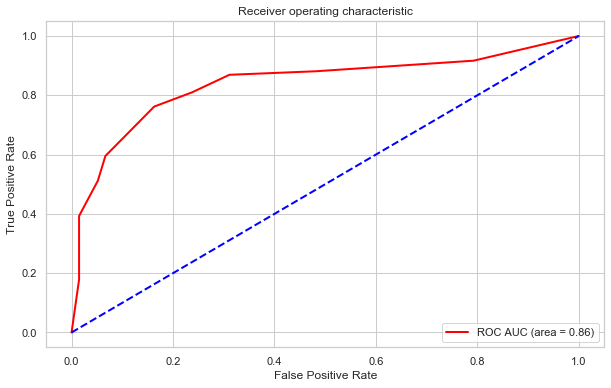

In [236]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

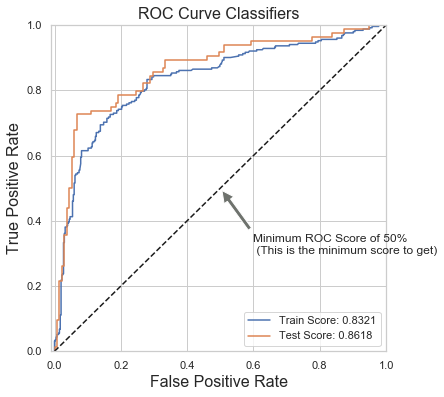

In [237]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()

#### Precision Recall curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.79')

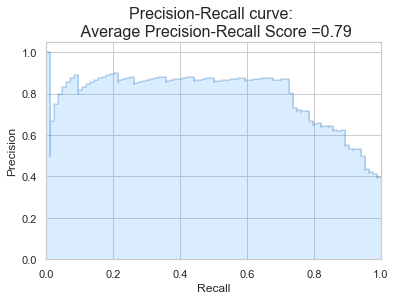

In [238]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_test_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.76')

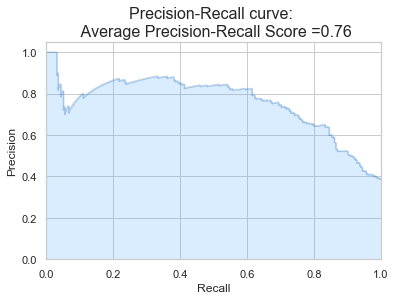

In [239]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_train_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

#### Precision Recall tradeoff

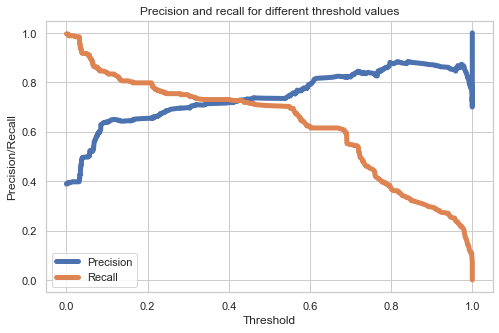

In [240]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

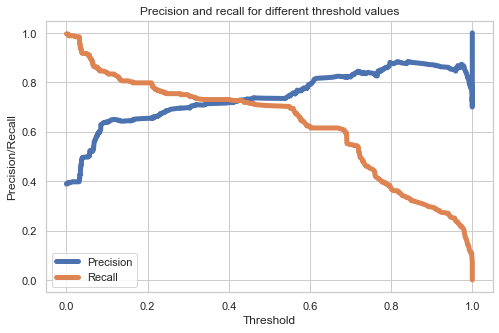

In [241]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## 10.9 - Decision Tree 
<a id="decision_tree"></a>

### 10.9.1 Train model

#### Train - Test split

In [242]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### K-Fold Cross Validation

In [243]:
kfold = KFold(n_splits = 10, random_state = 10)
cv_classifier = cross_val_score(DecisionTreeClassifier(),X_train,y_train,cv=kfold,scoring='accuracy')
cv_classifier

array([0.81818182, 0.72727273, 0.74242424, 0.72727273, 0.83333333,
       0.75757576, 0.6969697 , 0.72307692, 0.70769231, 0.76923077])

In [244]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*cv_classifier.mean(), 100*cv_classifier.std() * 2))

Accuracy: 75.03% (+/- 8.59%)


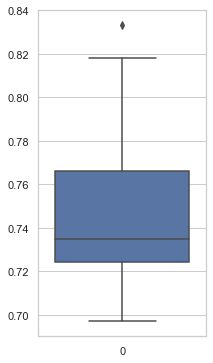

In [245]:
plt.figure(figsize=(3,6))
sns.boxplot(data=cv_classifier)
plt.show()

### 10.9.2 Prediction & Evaluation

In [246]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'Decision Tree')

Model Evaluation of Decision Tree
-----------------------------------------------------------
Train set
Accuracy:  0.9832572298325722
ROC AUC Score:  0.9993141289437586
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1       1.00      0.96      0.98       252

    accuracy                           0.98       657
   macro avg       0.99      0.98      0.98       657
weighted avg       0.98      0.98      0.98       657

-----------------------------------------------------------
Test set
Accuracy:  0.776255707762557
ROC AUC Score:  0.7678571428571429
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       135
           1       0.71      0.71      0.71        84

    accuracy                           0.78       219
   macro avg       0.76      0.76      0.76       219
weighted avg       0.78      0.78      0.78       219



### 10.9.3 Tuning hyper parameters

#### Apply Grid search

In [247]:
params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}
grid_search = GridSearchCV(DecisionTreeClassifier(), params)
# tree best estimator
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2,

#### Re-run with the best parameters

In [248]:
# tree best estimator
best_model = grid_search.best_estimator_
best_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### KFold Cross Validation

In [249]:
cv_classifier = cross_val_score(best_model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*cv_classifier.mean(), 100*cv_classifier.std() * 2))

Accuracy: 80.51% (+/- 13.24%)


In [250]:
cv_classifier

array([0.75757576, 0.86363636, 0.89393939, 0.72727273, 0.83333333,
       0.83333333, 0.75757576, 0.69230769, 0.8       , 0.89230769])

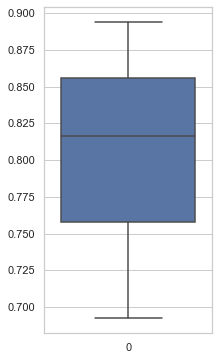

In [251]:
plt.figure(figsize=(3,6))
sns.boxplot(data=cv_classifier)
plt.show()

### 10.9.4 Predicting

In [252]:
prob_train_pred = classifier.predict_proba(X_train)
prob_test_pred = classifier.predict_proba(X_test)
prob_test_pred[0:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [253]:
# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

In [254]:
UtilityFunction.ModelEvaluation(classifier,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.9832572298325722
ROC AUC Score:  0.9993141289437586
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1       1.00      0.96      0.98       252

    accuracy                           0.98       657
   macro avg       0.99      0.98      0.98       657
weighted avg       0.98      0.98      0.98       657

-----------------------------------------------------------
Test set
Accuracy:  0.776255707762557
ROC AUC Score:  0.7667989417989419
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       135
           1       0.71      0.71      0.71        84

    accuracy                           0.78       219
   macro avg       0.76      0.76      0.76       219
weighted avg       0.78      0.78      0.78       219



### 10.9.5 Evaluating model

#### Summary

In [255]:
result_summary = pd.DataFrame(columns= ['Dataset',"accuracy", "roc_auc_score", "recall", "precision"] )
result_summary.loc[0,:] = ['Train',accuracy_score(y_train, y_train_pred), roc_auc_score(y_train, prob_train_pred[:,1]),recall_score(y_train, y_train_pred),precision_score(y_train, y_train_pred)]
result_summary.loc[1,:] = ['Test',accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, prob_test_pred[:,1]),recall_score(y_test, y_test_pred),precision_score(y_test, y_test_pred)]
result_summary

,Dataset,accuracy,roc_auc_score,recall,precision
0,Train,0.983257,0.999314,0.960317,0.995885
1,Test,0.776256,0.767857,0.714286,0.705882


#### Overall Accuracy

In [256]:
# On train set
print(classifier.score(X_train, y_train))
# On test set
print(classifier.score(X_test, y_test))
# Validation set
print(cv_classifier.mean(), cv_classifier.std())

0.9832572298325722
0.776255707762557
0.8051282051282052 0.06621228431232988


In [257]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.983 , Test: 0.776, Validation: 0.805


#### Confusion Matrix

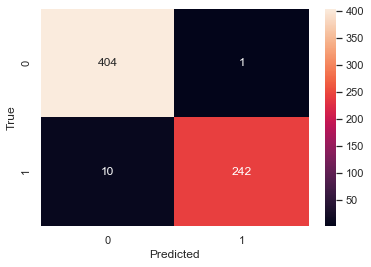

In [258]:
# Training set
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[404   1]
 [ 10 242]]


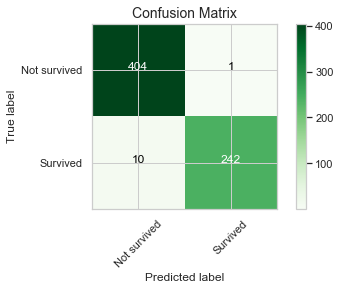

In [259]:
cm = confusion_matrix(y_train, y_train_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

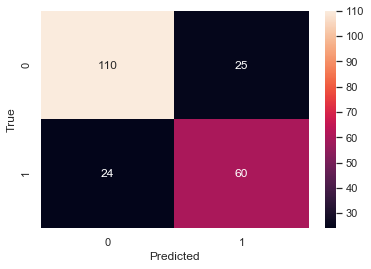

In [260]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=classifier.classes_,columns=classifier.classes_)
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[110  25]
 [ 24  60]]


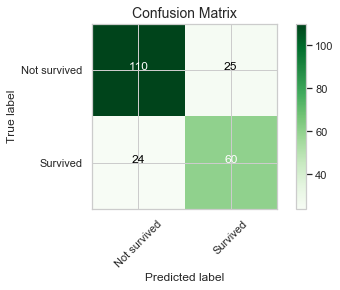

In [261]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

#### Classification Report

In [262]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1       1.00      0.96      0.98       252

    accuracy                           0.98       657
   macro avg       0.99      0.98      0.98       657
weighted avg       0.98      0.98      0.98       657



In [263]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       135
           1       0.71      0.71      0.71        84

    accuracy                           0.78       219
   macro avg       0.76      0.76      0.76       219
weighted avg       0.78      0.78      0.78       219



#### ROC AUC Score

In [264]:
# On train set
print(roc_auc_score(y_train, prob_train_pred[:,1]))
# On test set
roc_auc = roc_auc_score(y_test,prob_test_pred[:,1])
print(roc_auc)

0.9993141289437586
0.7678571428571429


In [265]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

rocauc_df = pd.DataFrame([fpr,tpr,thresholds]).T
rocauc_df.columns = ['fpr','tpr','thresholds']
rocauc_df.head(6)

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.185185,0.678571,1.000000
2,0.185185,0.714286,0.800000
3,0.207407,0.738095,0.500000
4,0.214815,0.738095,0.333333
5,1.000000,1.000000,0.000000


#### ROC Curve

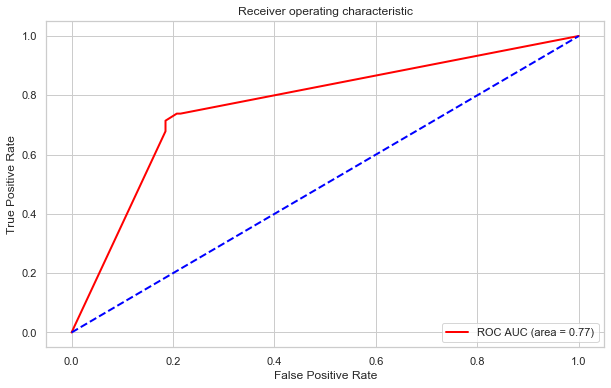

In [266]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

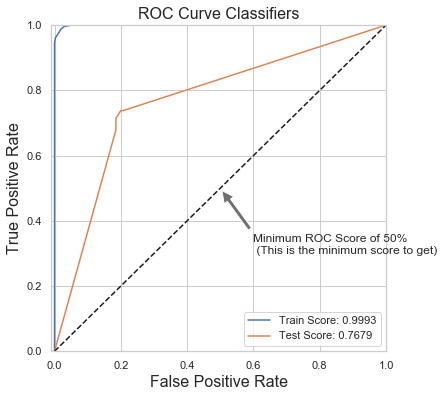

In [267]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


#### Precision Recall curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.61')

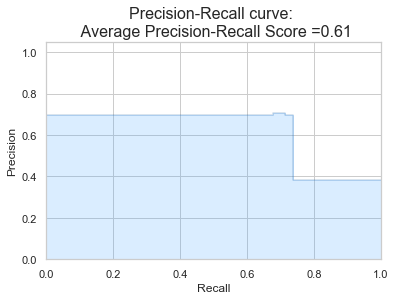

In [268]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_test_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =1.00')

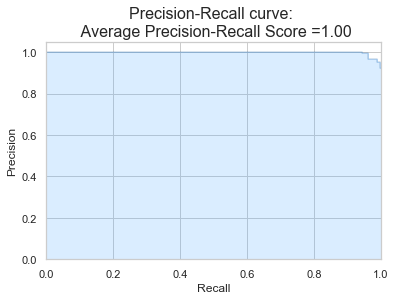

In [269]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_train_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

#### Precision Recall tradeoff

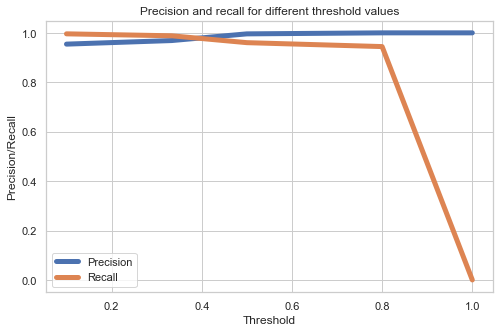

In [270]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

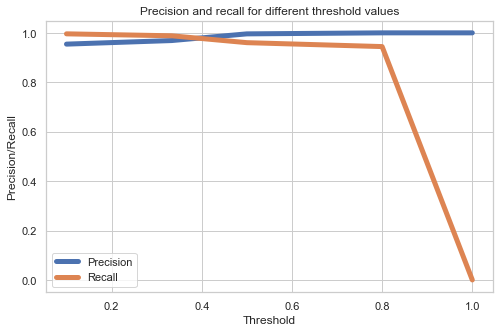

In [271]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

--------------------------------------------------------------------------

# DEEP LEARNING
<a id="deep_learning"></a>

### 2. Setup architecture of model

#### convert the class data to categorical values 

In [272]:
# convert the class data to categorical values - one-hot-encoded vectors
y1 = pd.get_dummies(y)
y1.iloc[:3]

,0,1
0,1,0
1,1,0
2,0,1


In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.3, random_state = 7)

In [8]:
import keras

Using TensorFlow backend.


In [20]:
# build a neural network using Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# define a function to build the keras model
def create_model(input_len, output_len):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim = input_len, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer = 'normal', activation='relu'))
    model.add(Dense(output_len, activation='sigmoid'))
    
    # compile model
    adam = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

classifier = create_model(X.shape[1],2)

print(classifier.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
Total params: 118
Trainable params: 118
Non-trainable params: 0
_________________________________________________________________
None


### 2. Setup architecture of model¶

In [21]:
# build a neural network using Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Start defining the model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

classifier = create_model()
print(classifier.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
None


### 3. Training model

In [14]:
# fit the model to the training data
classifier.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)
# classifier.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

Train on 525 samples, validate on 132 samples
Epoch 1/20
 - 2s - loss: 0.6575 - accuracy: 0.7086 - val_loss: 0.6042 - val_accuracy: 0.7045
Epoch 2/20
 - 0s - loss: 0.5517 - accuracy: 0.7257 - val_loss: 0.4853 - val_accuracy: 0.7652
Epoch 3/20
 - 0s - loss: 0.4843 - accuracy: 0.7790 - val_loss: 0.4155 - val_accuracy: 0.8333
Epoch 4/20
 - 0s - loss: 0.4623 - accuracy: 0.7867 - val_loss: 0.3951 - val_accuracy: 0.8333
Epoch 5/20
 - 0s - loss: 0.4457 - accuracy: 0.7924 - val_loss: 0.4026 - val_accuracy: 0.8333
Epoch 6/20
 - 0s - loss: 0.4359 - accuracy: 0.8000 - val_loss: 0.4057 - val_accuracy: 0.8030
Epoch 7/20
 - 0s - loss: 0.4366 - accuracy: 0.8133 - val_loss: 0.3795 - val_accuracy: 0.8333
Epoch 8/20
 - 0s - loss: 0.4265 - accuracy: 0.8190 - val_loss: 0.3939 - val_accuracy: 0.8258
Epoch 9/20
 - 0s - loss: 0.4215 - accuracy: 0.8190 - val_loss: 0.3785 - val_accuracy: 0.8409
Epoch 10/20
 - 0s - loss: 0.4240 - accuracy: 0.8210 - val_loss: 0.3855 - val_accuracy: 0.8258
Epoch 11/20
 - 0s - los

### 4. Predicting

In [15]:
y_train_pred = classifier.predict_classes(X_train, batch_size=200, verbose=0)
prob_train_pred = classifier.predict(X_train, batch_size=200, verbose=0)

y_test_pred = classifier.predict_classes(X_test, batch_size=200, verbose=0)
prob_test_pred = classifier.predict(X_test, batch_size=200, verbose=0)

In [16]:
prob_test_pred[0:5]

array([[0.5396217 ],
       [0.6896481 ],
       [0.49081123],
       [0.73573905],
       [0.1669598 ]], dtype=float32)

In [17]:
y_train_pred[0:5]

array([[0],
       [0],
       [1],
       [1],
       [0]])

### 6. Predicting

In [18]:
y_train_pred = classifier.predict_classes(X_train, batch_size=200, verbose=0)
prob_train_pred = classifier.predict(X_train, batch_size=200, verbose=0)

y_test_pred = classifier.predict_classes(X_test, batch_size=200, verbose=0)
prob_test_pred = classifier.predict(X_test, batch_size=200, verbose=0)

### 7. Evaluating models

#### Summary

In [19]:
def ModelEvaluation(model,X_train,y_train,X_test,y_test,name):
    print('Model Evaluation of ' + name)

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred))
    cm_df = pd.DataFrame(confusion_matrix(y_train,y_train_pred))
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred))
    cm_df = pd.DataFrame(confusion_matrix(y_test,y_test_pred))
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_test, y_test_pred))
    
ModelEvaluation(model,X_train,y_train,X_test,y_test,'RF')

NameError: name 'model' is not defined

#### Accuracy score

In [392]:
# On train set
print(accuracy_score(y_train, y_train_pred))
# On test set
print(accuracy_score(y_test, y_test_pred))

0.8538812785388128
0.821917808219178


In [393]:
print('Train: %.3f , Test: %.3f, Validation: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred),cv_classifier.mean()))

Train: 0.854 , Test: 0.822, Validation: 0.797


#### Confusion matrix

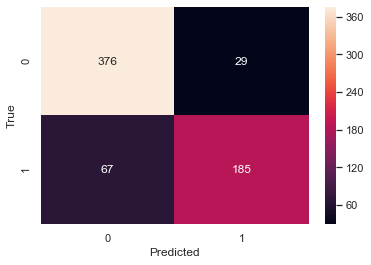

In [396]:
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred))
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[376  29]
 [ 67 185]]


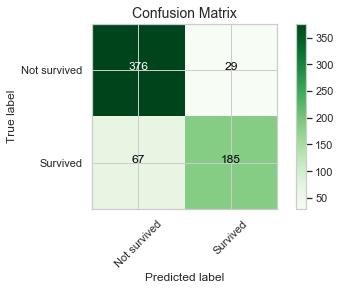

In [398]:
cm = confusion_matrix(y_train, y_train_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

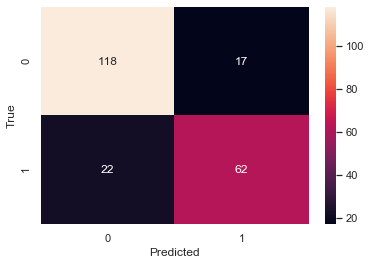

In [401]:
# Test set
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

Confusion matrix, without normalization
[[118  17]
 [ 22  62]]


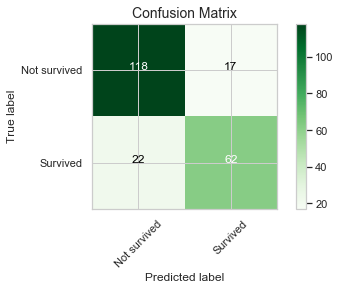

In [403]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['Not survived', 'Survived']
UtilityFunction.plot_confusion_matrix(cm , labels, title="Confusion Matrix", cmap=plt.cm.Greens, normalize=False)

#### Classification report

In [405]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       405
           1       0.86      0.73      0.79       252

    accuracy                           0.85       657
   macro avg       0.86      0.83      0.84       657
weighted avg       0.85      0.85      0.85       657



In [406]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       135
           1       0.78      0.74      0.76        84

    accuracy                           0.82       219
   macro avg       0.81      0.81      0.81       219
weighted avg       0.82      0.82      0.82       219



#### ROC AUC Score

In [408]:
roc_auc_score(y_train, prob_train_pred)

0.8764991181657849

In [409]:
roc_auc_score(y_test, prob_test_pred)

0.881305114638448

#### ROC Curve

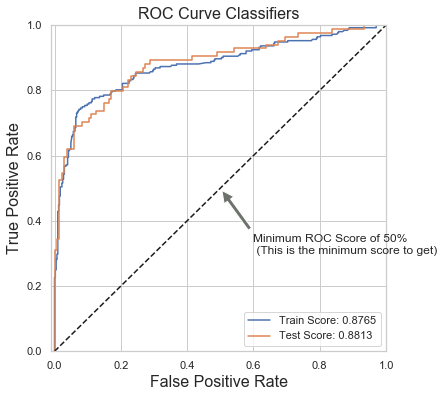

In [410]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred)
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred)

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred)))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred)))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


#### Precision Recall Curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.86')

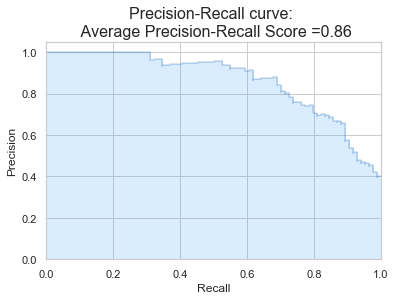

In [411]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_test_pred
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.86')

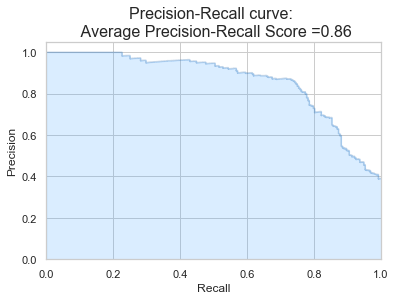

In [413]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_train_pred
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

#### Precision Recall tradeoff

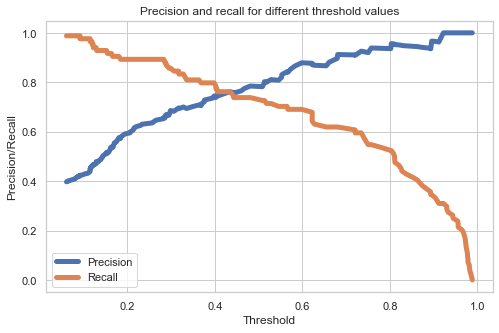

In [412]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

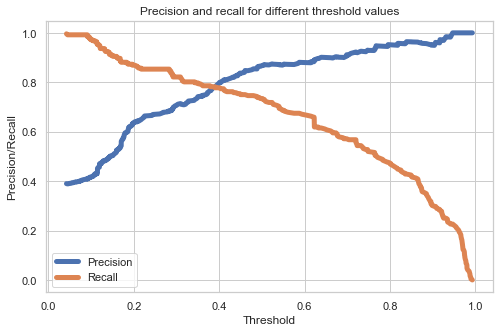

In [414]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Tuning hyper-parameters

In [416]:
# Do a grid search for the optimal batch size and number of epochs
# import necessary packages
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(9, input_dim = 9, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, verbose = 1)

# define the grid search parameters
batch_size = [10, 20, 40]
epochs = [10, 50, 100]

# make a dictionary of the grid search parameters
param_grid = dict(batch_size=batch_size, epochs=epochs)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_train, y_train)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] batch_size=10, epochs=10 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
438/438 [==============================] - 0s 683us/step - loss: 0.6401 - accuracy: 0.6005
Epoch 2/10
438/438 [==============================] - 0s 146us/step - loss: 0.5419 - accuracy: 0.7397
Epoch 3/10
438/438 [==============================] - 0s 143us/step - loss: 0.4964 - accuracy: 0.7922
Epoch 4/10
438/438 [==============================] - 0s 143us/step - loss: 0.4827 - accuracy: 0.7785
Epoch 5/10
438/438 [==============================] - 0s 143us/step - loss: 0.4758 - accuracy: 0.7785
Epoch 6/10
438/438 [==============================] - 0s 143us/step - loss: 0.4608 - accuracy: 0.7922
Epoch 7/10
438/438 [==============================] - 0s 136us/step - loss: 0.4634 - accuracy: 0.7922
Epoch 8/10
438/438 [==============================] - 0s 143us/step - loss: 0.4535 - accuracy: 0.8082
Epoch 9/10
438/438 [==============================] - 0s 143us/step - loss: 0.4511 - accuracy: 0.8059
Epoch 10/10
219/219 [==============================] - 0s 285us/step
[CV] ........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


Epoch 1/10
438/438 [==============================] - 0s 713us/step - loss: 0.6496 - accuracy: 0.7100
Epoch 2/10
438/438 [==============================] - 0s 143us/step - loss: 0.5529 - accuracy: 0.7968
Epoch 3/10
438/438 [==============================] - 0s 143us/step - loss: 0.4835 - accuracy: 0.8151
Epoch 4/10
438/438 [==============================] - 0s 107us/step - loss: 0.4493 - accuracy: 0.8311
Epoch 5/10
438/438 [==============================] - 0s 107us/step - loss: 0.4197 - accuracy: 0.8333
Epoch 6/10
438/438 [==============================] - 0s 150us/step - loss: 0.4058 - accuracy: 0.8447
Epoch 7/10
438/438 [==============================] - 0s 143us/step - loss: 0.3974 - accuracy: 0.8493
Epoch 8/10
438/438 [==============================] - 0s 143us/step - loss: 0.3992 - accuracy: 0.8333
Epoch 9/10
438/438 [==============================] - 0s 143us/step - loss: 0.3811 - accuracy: 0.8516
Epoch 10/10
219/219 [==============================] - 0s 285us/step
[CV] ........

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


Epoch 1/10
438/438 [==============================] - 0s 784us/step - loss: 0.6140 - accuracy: 0.6484
Epoch 2/10
438/438 [==============================] - 0s 178us/step - loss: 0.5158 - accuracy: 0.7694
Epoch 3/10
438/438 [==============================] - 0s 178us/step - loss: 0.4872 - accuracy: 0.7945
Epoch 4/10
438/438 [==============================] - 0s 143us/step - loss: 0.4694 - accuracy: 0.7968
Epoch 5/10
438/438 [==============================] - 0s 178us/step - loss: 0.4444 - accuracy: 0.7991
Epoch 6/10
438/438 [==============================] - 0s 107us/step - loss: 0.4454 - accuracy: 0.8059
Epoch 7/10
438/438 [==============================] - 0s 143us/step - loss: 0.4257 - accuracy: 0.8174
Epoch 8/10
438/438 [==============================] - 0s 149us/step - loss: 0.4168 - accuracy: 0.8219
Epoch 9/10
438/438 [==============================] - 0s 143us/step - loss: 0.4121 - accuracy: 0.8288
Epoch 10/10
219/219 [==============================] - 0s 357us/step
[CV] ........

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s


Epoch 1/50
438/438 [==============================] - 0s 713us/step - loss: 0.6359 - accuracy: 0.5982
Epoch 2/50
438/438 [==============================] - 0s 143us/step - loss: 0.5613 - accuracy: 0.6872
Epoch 3/50
438/438 [==============================] - 0s 143us/step - loss: 0.5336 - accuracy: 0.7694
Epoch 4/50
438/438 [==============================] - 0s 143us/step - loss: 0.5256 - accuracy: 0.7808
Epoch 5/50
438/438 [==============================] - 0s 107us/step - loss: 0.5063 - accuracy: 0.8059
Epoch 6/50
438/438 [==============================] - 0s 143us/step - loss: 0.4999 - accuracy: 0.7968
Epoch 7/50
438/438 [==============================] - 0s 107us/step - loss: 0.5015 - accuracy: 0.7900
Epoch 8/50
438/438 [==============================] - 0s 107us/step - loss: 0.5019 - accuracy: 0.7945
Epoch 9/50
438/438 [==============================] - 0s 107us/step - loss: 0.4885 - accuracy: 0.8037
Epoch 10/50
438/438 [==============================] - 0s 143us/step - loss: 0.484

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.8s remaining:    0.0s


Epoch 1/50
438/438 [==============================] - 0s 759us/step - loss: 0.6637 - accuracy: 0.6986
Epoch 2/50
438/438 [==============================] - 0s 178us/step - loss: 0.5739 - accuracy: 0.7877
Epoch 3/50
438/438 [==============================] - 0s 143us/step - loss: 0.5149 - accuracy: 0.8174
Epoch 4/50
438/438 [==============================] - 0s 178us/step - loss: 0.4715 - accuracy: 0.8082
Epoch 5/50
438/438 [==============================] - 0s 143us/step - loss: 0.4393 - accuracy: 0.8288
Epoch 6/50
438/438 [==============================] - 0s 143us/step - loss: 0.4193 - accuracy: 0.8288
Epoch 7/50
438/438 [==============================] - 0s 143us/step - loss: 0.4118 - accuracy: 0.8402
Epoch 8/50
438/438 [==============================] - 0s 107us/step - loss: 0.3987 - accuracy: 0.8425
Epoch 9/50
438/438 [==============================] - 0s 107us/step - loss: 0.4000 - accuracy: 0.8356
Epoch 10/50
438/438 [==============================] - 0s 107us/step - loss: 0.382

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s remaining:    0.0s


Epoch 1/50
438/438 [==============================] - 0s 827us/step - loss: 0.6521 - accuracy: 0.6050
Epoch 2/50
438/438 [==============================] - 0s 146us/step - loss: 0.5720 - accuracy: 0.6438
Epoch 3/50
438/438 [==============================] - 0s 143us/step - loss: 0.5332 - accuracy: 0.7671
Epoch 4/50
438/438 [==============================] - 0s 143us/step - loss: 0.5150 - accuracy: 0.7922
Epoch 5/50
438/438 [==============================] - 0s 107us/step - loss: 0.4888 - accuracy: 0.8128
Epoch 6/50
438/438 [==============================] - 0s 143us/step - loss: 0.4878 - accuracy: 0.7968
Epoch 7/50
438/438 [==============================] - 0s 107us/step - loss: 0.4771 - accuracy: 0.7991
Epoch 8/50
438/438 [==============================] - 0s 120us/step - loss: 0.4672 - accuracy: 0.8037
Epoch 9/50
438/438 [==============================] - 0s 107us/step - loss: 0.4748 - accuracy: 0.8082
Epoch 10/50
438/438 [==============================] - 0s 107us/step - loss: 0.462

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   16.5s remaining:    0.0s


Epoch 1/100
438/438 [==============================] - 0s 927us/step - loss: 0.6133 - accuracy: 0.6142
Epoch 2/100
438/438 [==============================] - 0s 178us/step - loss: 0.5460 - accuracy: 0.7374
Epoch 3/100
438/438 [==============================] - 0s 178us/step - loss: 0.5192 - accuracy: 0.7945
Epoch 4/100
438/438 [==============================] - 0s 107us/step - loss: 0.5086 - accuracy: 0.8037
Epoch 5/100
438/438 [==============================] - 0s 107us/step - loss: 0.5011 - accuracy: 0.8059
Epoch 6/100
438/438 [==============================] - 0s 107us/step - loss: 0.4926 - accuracy: 0.7922
Epoch 7/100
438/438 [==============================] - 0s 107us/step - loss: 0.4845 - accuracy: 0.8151
Epoch 8/100
438/438 [==============================] - 0s 143us/step - loss: 0.4786 - accuracy: 0.8037
Epoch 9/100
438/438 [==============================] - 0s 178us/step - loss: 0.4647 - accuracy: 0.8128
Epoch 10/100
438/438 [==============================] - 0s 143us/step - l

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   23.5s remaining:    0.0s


Epoch 1/100
438/438 [==============================] - 0s 792us/step - loss: 0.6759 - accuracy: 0.6279
Epoch 2/100
438/438 [==============================] - 0s 107us/step - loss: 0.6075 - accuracy: 0.7534
Epoch 3/100
438/438 [==============================] - 0s 146us/step - loss: 0.5309 - accuracy: 0.8128
Epoch 4/100
438/438 [==============================] - 0s 107us/step - loss: 0.4764 - accuracy: 0.8311
Epoch 5/100
438/438 [==============================] - 0s 107us/step - loss: 0.4437 - accuracy: 0.8174
Epoch 6/100
438/438 [==============================] - 0s 143us/step - loss: 0.4267 - accuracy: 0.8311
Epoch 7/100
438/438 [==============================] - 0s 107us/step - loss: 0.4132 - accuracy: 0.8288
Epoch 8/100
438/438 [==============================] - 0s 143us/step - loss: 0.4019 - accuracy: 0.8333
Epoch 9/100
438/438 [==============================] - 0s 107us/step - loss: 0.3919 - accuracy: 0.8425
Epoch 10/100
438/438 [==============================] - 0s 143us/step - l

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   30.7s remaining:    0.0s


Epoch 1/100
438/438 [==============================] - 0s 988us/step - loss: 0.6188 - accuracy: 0.5959
Epoch 2/100
438/438 [==============================] - 0s 146us/step - loss: 0.5494 - accuracy: 0.7443
Epoch 3/100
438/438 [==============================] - 0s 143us/step - loss: 0.5098 - accuracy: 0.7763
Epoch 4/100
438/438 [==============================] - 0s 143us/step - loss: 0.4895 - accuracy: 0.8082
Epoch 5/100
438/438 [==============================] - 0s 107us/step - loss: 0.4596 - accuracy: 0.8379
Epoch 6/100
438/438 [==============================] - 0s 143us/step - loss: 0.4526 - accuracy: 0.8196
Epoch 7/100
438/438 [==============================] - 0s 143us/step - loss: 0.4467 - accuracy: 0.8174
Epoch 8/100
438/438 [==============================] - 0s 107us/step - loss: 0.4494 - accuracy: 0.8379
Epoch 9/100
438/438 [==============================] - 0s 143us/step - loss: 0.4260 - accuracy: 0.8402
Epoch 10/100
438/438 [==============================] - 0s 143us/step - l

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.1s remaining:    0.0s


Epoch 1/10
438/438 [==============================] - 0s 835us/step - loss: 0.6553 - accuracy: 0.6096
Epoch 2/10
438/438 [==============================] - 0s 107us/step - loss: 0.5694 - accuracy: 0.6918
Epoch 3/10
438/438 [==============================] - 0s 71us/step - loss: 0.5229 - accuracy: 0.7694
Epoch 4/10
438/438 [==============================] - 0s 107us/step - loss: 0.4759 - accuracy: 0.7991
Epoch 5/10
438/438 [==============================] - 0s 71us/step - loss: 0.4590 - accuracy: 0.8014
Epoch 6/10
438/438 [==============================] - 0s 71us/step - loss: 0.4517 - accuracy: 0.8037
Epoch 7/10
438/438 [==============================] - 0s 78us/step - loss: 0.4444 - accuracy: 0.8105
Epoch 8/10
438/438 [==============================] - 0s 71us/step - loss: 0.4446 - accuracy: 0.8059
Epoch 9/10
438/438 [==============================] - 0s 71us/step - loss: 0.4369 - accuracy: 0.8219
Epoch 10/10
219/219 [==============================] - 0s 437us/step
[CV] ............ b

438/438 [==============================] - 0s 71us/step - loss: 0.3766 - accuracy: 0.8516
Epoch 21/50
438/438 [==============================] - 0s 71us/step - loss: 0.3732 - accuracy: 0.8607
Epoch 22/50
438/438 [==============================] - 0s 71us/step - loss: 0.3655 - accuracy: 0.8653
Epoch 23/50
438/438 [==============================] - 0s 71us/step - loss: 0.3649 - accuracy: 0.8607
Epoch 24/50
438/438 [==============================] - 0s 71us/step - loss: 0.3646 - accuracy: 0.8562
Epoch 25/50
438/438 [==============================] - 0s 78us/step - loss: 0.3696 - accuracy: 0.8516
Epoch 26/50
438/438 [==============================] - 0s 71us/step - loss: 0.3610 - accuracy: 0.8607
Epoch 27/50
438/438 [==============================] - 0s 71us/step - loss: 0.3677 - accuracy: 0.8562
Epoch 28/50
438/438 [==============================] - 0s 71us/step - loss: 0.3608 - accuracy: 0.8676
Epoch 29/50
438/438 [==============================] - 0s 71us/step - loss: 0.3528 - accuracy:

Epoch 48/100
438/438 [==============================] - 0s 71us/step - loss: 0.3790 - accuracy: 0.8447
Epoch 49/100
438/438 [==============================] - 0s 107us/step - loss: 0.3859 - accuracy: 0.8447
Epoch 50/100
438/438 [==============================] - 0s 107us/step - loss: 0.3740 - accuracy: 0.8516
Epoch 51/100
438/438 [==============================] - 0s 107us/step - loss: 0.3774 - accuracy: 0.8516
Epoch 52/100
438/438 [==============================] - 0s 107us/step - loss: 0.3775 - accuracy: 0.8356
Epoch 53/100
438/438 [==============================] - 0s 71us/step - loss: 0.3738 - accuracy: 0.8425
Epoch 54/100
438/438 [==============================] - 0s 71us/step - loss: 0.3698 - accuracy: 0.8447
Epoch 55/100
438/438 [==============================] - 0s 71us/step - loss: 0.3765 - accuracy: 0.8379
Epoch 56/100
438/438 [==============================] - 0s 71us/step - loss: 0.3867 - accuracy: 0.8447
Epoch 57/100
438/438 [==============================] - 0s 107us/step

438/438 [==============================] - 0s 71us/step - loss: 0.6206 - accuracy: 0.7557
Epoch 3/100
438/438 [==============================] - 0s 71us/step - loss: 0.5640 - accuracy: 0.7694
Epoch 4/100
438/438 [==============================] - 0s 71us/step - loss: 0.5147 - accuracy: 0.7945
Epoch 5/100
438/438 [==============================] - 0s 71us/step - loss: 0.4787 - accuracy: 0.8219
Epoch 6/100
438/438 [==============================] - 0s 71us/step - loss: 0.4632 - accuracy: 0.8265
Epoch 7/100
438/438 [==============================] - 0s 71us/step - loss: 0.4460 - accuracy: 0.8379
Epoch 8/100
438/438 [==============================] - 0s 71us/step - loss: 0.4374 - accuracy: 0.8402
Epoch 9/100
438/438 [==============================] - 0s 78us/step - loss: 0.4222 - accuracy: 0.8425
Epoch 10/100
438/438 [==============================] - 0s 71us/step - loss: 0.4165 - accuracy: 0.8311
Epoch 11/100
438/438 [==============================] - 0s 71us/step - loss: 0.4113 - accurac

438/438 [==============================] - 0s 36us/step - loss: 0.4168 - accuracy: 0.8379
Epoch 24/50
438/438 [==============================] - 0s 36us/step - loss: 0.4169 - accuracy: 0.8379
Epoch 25/50
438/438 [==============================] - 0s 36us/step - loss: 0.4122 - accuracy: 0.8425
Epoch 26/50
438/438 [==============================] - 0s 71us/step - loss: 0.4113 - accuracy: 0.8425
Epoch 27/50
438/438 [==============================] - 0s 36us/step - loss: 0.4099 - accuracy: 0.8402
Epoch 28/50
438/438 [==============================] - 0s 36us/step - loss: 0.4078 - accuracy: 0.8425
Epoch 29/50
438/438 [==============================] - 0s 36us/step - loss: 0.4089 - accuracy: 0.8539
Epoch 30/50
438/438 [==============================] - 0s 36us/step - loss: 0.4088 - accuracy: 0.8356
Epoch 31/50
438/438 [==============================] - 0s 36us/step - loss: 0.4036 - accuracy: 0.8447
Epoch 32/50
438/438 [==============================] - 0s 36us/step - loss: 0.4095 - accuracy:

438/438 [==============================] - 0s 36us/step - loss: 0.3986 - accuracy: 0.8447
Epoch 28/100
438/438 [==============================] - 0s 71us/step - loss: 0.3946 - accuracy: 0.8379
Epoch 29/100
438/438 [==============================] - 0s 42us/step - loss: 0.3916 - accuracy: 0.8402
Epoch 30/100
438/438 [==============================] - 0s 71us/step - loss: 0.3969 - accuracy: 0.8425
Epoch 31/100
438/438 [==============================] - 0s 36us/step - loss: 0.3913 - accuracy: 0.8379
Epoch 32/100
438/438 [==============================] - 0s 36us/step - loss: 0.3874 - accuracy: 0.8379
Epoch 33/100
438/438 [==============================] - 0s 36us/step - loss: 0.3893 - accuracy: 0.8447
Epoch 34/100
438/438 [==============================] - 0s 36us/step - loss: 0.3965 - accuracy: 0.8425
Epoch 35/100
438/438 [==============================] - 0s 71us/step - loss: 0.3851 - accuracy: 0.8379
Epoch 36/100
438/438 [==============================] - 0s 36us/step - loss: 0.3860 - 

438/438 [==============================] - 0s 71us/step - loss: 0.3318 - accuracy: 0.8676
Epoch 84/100
438/438 [==============================] - 0s 36us/step - loss: 0.3307 - accuracy: 0.8699
Epoch 85/100
438/438 [==============================] - 0s 71us/step - loss: 0.3318 - accuracy: 0.8699
Epoch 86/100
438/438 [==============================] - 0s 36us/step - loss: 0.3308 - accuracy: 0.8607
Epoch 87/100
438/438 [==============================] - 0s 71us/step - loss: 0.3305 - accuracy: 0.8744
Epoch 88/100
438/438 [==============================] - 0s 36us/step - loss: 0.3292 - accuracy: 0.8699
Epoch 89/100
438/438 [==============================] - 0s 36us/step - loss: 0.3296 - accuracy: 0.8584
Epoch 90/100
438/438 [==============================] - 0s 36us/step - loss: 0.3256 - accuracy: 0.8676
Epoch 91/100
438/438 [==============================] - 0s 36us/step - loss: 0.3270 - accuracy: 0.8721
Epoch 92/100
438/438 [==============================] - 0s 71us/step - loss: 0.3282 - 

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.7min finished


Epoch 1/50
657/657 [==============================] - 0s 690us/step - loss: 0.6543 - accuracy: 0.6149
Epoch 2/50
657/657 [==============================] - 0s 71us/step - loss: 0.5695 - accuracy: 0.6210
Epoch 3/50
657/657 [==============================] - 0s 95us/step - loss: 0.5272 - accuracy: 0.7702
Epoch 4/50
657/657 [==============================] - 0s 71us/step - loss: 0.5035 - accuracy: 0.8128
Epoch 5/50
657/657 [==============================] - 0s 71us/step - loss: 0.4900 - accuracy: 0.8052
Epoch 6/50
657/657 [==============================] - 0s 71us/step - loss: 0.4785 - accuracy: 0.8128
Epoch 7/50
657/657 [==============================] - 0s 95us/step - loss: 0.4731 - accuracy: 0.8174
Epoch 8/50
657/657 [==============================] - 0s 71us/step - loss: 0.4678 - accuracy: 0.8082
Epoch 9/50
657/657 [==============================] - 0s 71us/step - loss: 0.4625 - accuracy: 0.8143
Epoch 10/50
657/657 [==============================] - 0s 71us/step - loss: 0.4639 - accur

In [417]:
# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Best: 0.8112633228302002, using {'batch_size': 20, 'epochs': 50}
0.8051750461260477 (0.018765341976714582) with: {'batch_size': 10, 'epochs': 10}
0.8036529620488485 (0.013442561108131813) with: {'batch_size': 10, 'epochs': 50}
0.8021308978398641 (0.02184583216872653) with: {'batch_size': 10, 'epochs': 100}
0.792998472849528 (0.028230197006668106) with: {'batch_size': 20, 'epochs': 10}
0.8112633228302002 (0.026971130591450874) with: {'batch_size': 20, 'epochs': 50}
0.7990867694218954 (0.017085202712125002) with: {'batch_size': 20, 'epochs': 100}
0.7869102160135905 (0.007761062377898091) with: {'batch_size': 40, 'epochs': 10}
0.797564685344696 (0.014115087791120726) with: {'batch_size': 40, 'epochs': 50}
0.7823440035184225 (0.019132124730987705) with: {'batch_size': 40, 'epochs': 100}


In [418]:
# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Best: 0.8112633228302002, using {'batch_size': 20, 'epochs': 50}
0.8051750461260477 (0.018765341976714582) with: {'batch_size': 10, 'epochs': 10}
0.8036529620488485 (0.013442561108131813) with: {'batch_size': 10, 'epochs': 50}
0.8021308978398641 (0.02184583216872653) with: {'batch_size': 10, 'epochs': 100}
0.792998472849528 (0.028230197006668106) with: {'batch_size': 20, 'epochs': 10}
0.8112633228302002 (0.026971130591450874) with: {'batch_size': 20, 'epochs': 50}
0.7990867694218954 (0.017085202712125002) with: {'batch_size': 20, 'epochs': 100}
0.7869102160135905 (0.007761062377898091) with: {'batch_size': 40, 'epochs': 10}
0.797564685344696 (0.014115087791120726) with: {'batch_size': 40, 'epochs': 50}
0.7823440035184225 (0.019132124730987705) with: {'batch_size': 40, 'epochs': 100}


In [420]:
# Do a grid search for learning rate and dropout rate
# import necessary packages
from keras.layers import Dropout

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(learn_rate, dropout_rate):
    # create model
    model = Sequential()
    model.add(Dense(9, input_dim = 9, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = 50, batch_size = 20, verbose = 0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2]

# make a dictionary of the grid search parameters
param_grid = dict(learn_rate=learn_rate, dropout_rate=dropout_rate)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_train, y_train)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.808, total=   4.3s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.776, total=   4.2s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.804, total=   4.5s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.804, total=   4.5s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.4s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.799, total=   4.5s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.9s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.749, total=   4.8s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.7s remaining:    0.0s


[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.785, total=   4.6s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   31.3s remaining:    0.0s


[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.795, total=   4.8s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   36.1s remaining:    0.0s


[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.804, total=   4.9s
[CV] dropout_rate=0.1, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.9s remaining:    0.0s


[CV] .. dropout_rate=0.1, learn_rate=0.001, score=0.817, total=   5.0s
[CV] dropout_rate=0.1, learn_rate=0.001 ..............................
[CV] .. dropout_rate=0.1, learn_rate=0.001, score=0.776, total=   6.0s
[CV] dropout_rate=0.1, learn_rate=0.001 ..............................
[CV] .. dropout_rate=0.1, learn_rate=0.001, score=0.813, total=   5.9s
[CV] dropout_rate=0.1, learn_rate=0.01 ...............................
[CV] ... dropout_rate=0.1, learn_rate=0.01, score=0.790, total=   5.4s
[CV] dropout_rate=0.1, learn_rate=0.01 ...............................
[CV] ... dropout_rate=0.1, learn_rate=0.01, score=0.799, total=   5.7s
[CV] dropout_rate=0.1, learn_rate=0.01 ...............................
[CV] ... dropout_rate=0.1, learn_rate=0.01, score=0.813, total=   5.6s
[CV] dropout_rate=0.1, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.1, learn_rate=0.1, score=0.845, total=   6.2s
[CV] dropout_rate=0.1, learn_rate=0.1 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.5min finished


Best: 0.8112633029619852, using {'dropout_rate': 0.1, 'learn_rate': 0.1}
0.7960426211357117 (0.014115087791120726) with: {'dropout_rate': 0.0, 'learn_rate': 0.001}
0.7838660478591919 (0.024824200059451906) with: {'dropout_rate': 0.0, 'learn_rate': 0.01}
0.7945205370585123 (0.007456585669036804) with: {'dropout_rate': 0.0, 'learn_rate': 0.1}
0.8021308978398641 (0.018391227718297612) with: {'dropout_rate': 0.1, 'learn_rate': 0.001}
0.8006088336308798 (0.009382659707688307) with: {'dropout_rate': 0.1, 'learn_rate': 0.01}
0.8112633029619852 (0.024824217114229753) with: {'dropout_rate': 0.1, 'learn_rate': 0.1}
0.7899543245633444 (0.012915199278688293) with: {'dropout_rate': 0.2, 'learn_rate': 0.001}
0.7945205569267273 (0.01118489067028252) with: {'dropout_rate': 0.2, 'learn_rate': 0.01}
0.7899543444315592 (0.01491319567154809) with: {'dropout_rate': 0.2, 'learn_rate': 0.1}


In [421]:
# Do a grid search to optimize kernel initialization and activation functions
# import necessary packages

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(activation, init):
    # create model
    model = Sequential()
    model.add(Dense(9, input_dim = 9, kernel_initializer= init, activation= activation))
    model.add(Dense(4, input_dim = 8, kernel_initializer= init, activation= activation))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = 50, batch_size = 20, verbose = 0)

# define the grid search parameters
activation = ['softmax', 'relu', 'tanh', 'linear']
init = ['uniform', 'normal', 'zero']

# make a dictionary of the grid search parameters
param_grid = dict(activation = activation, init = init)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_train, y_train)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... activation=softmax, init=uniform, score=0.822, total=   7.0s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.712, total=   7.0s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.753, total=   7.0s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.822, total=   6.6s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.5s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.717, total=   6.5s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.0s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.790, total=   8.0s
[CV] activation=softmax, init=zero ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   42.0s remaining:    0.0s


[CV] ....... activation=softmax, init=zero, score=0.639, total=   7.2s
[CV] activation=softmax, init=zero ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   49.2s remaining:    0.0s


[CV] ....... activation=softmax, init=zero, score=0.575, total=   7.3s
[CV] activation=softmax, init=zero ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   56.5s remaining:    0.0s


[CV] ....... activation=softmax, init=zero, score=0.635, total=   7.2s
[CV] activation=relu, init=uniform ...................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] ....... activation=relu, init=uniform, score=0.804, total=   7.7s
[CV] activation=relu, init=uniform ...................................
[CV] ....... activation=relu, init=uniform, score=0.772, total=   7.6s
[CV] activation=relu, init=uniform ...................................
[CV] ....... activation=relu, init=uniform, score=0.822, total=   8.0s
[CV] activation=relu, init=normal ....................................
[CV] ........ activation=relu, init=normal, score=0.826, total=  10.4s
[CV] activation=relu, init=normal ....................................
[CV] ........ activation=relu, init=normal, score=0.776, total=   8.3s
[CV] activation=relu, init=normal ....................................
[CV] ........ activation=relu, init=normal, score=0.808, total=   8.2s
[CV] activation=relu, init=zero ......................................
[CV] .......... activation=relu, init=zero, score=0.639, total=   9.4s
[CV] activation=relu, init=zero ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  5.2min finished


Best: 0.8036529819170634, using {'activation': 'relu', 'init': 'normal'}
0.7625570893287659 (0.045203175398491724) with: {'activation': 'softmax', 'init': 'uniform'}
0.77625572681427 (0.043955956243919916) with: {'activation': 'softmax', 'init': 'normal'}
0.6164383689562479 (0.029118915038147463) with: {'activation': 'softmax', 'init': 'zero'}
0.7990867495536804 (0.02075828438595466) with: {'activation': 'relu', 'init': 'uniform'}
0.8036529819170634 (0.0207582625338263) with: {'activation': 'relu', 'init': 'normal'}
0.6164383689562479 (0.029118915038147463) with: {'activation': 'relu', 'init': 'zero'}
0.8006088336308798 (0.010762675431539914) with: {'activation': 'tanh', 'init': 'uniform'}
0.7945205370585123 (0.009864131056345522) with: {'activation': 'tanh', 'init': 'normal'}
0.6164383689562479 (0.029118915038147463) with: {'activation': 'tanh', 'init': 'zero'}
0.7960426211357117 (0.009382682269033748) with: {'activation': 'linear', 'init': 'uniform'}
0.797564685344696 (0.011390133371

In [422]:
# Do a grid search to find the optimal number of neurons in each hidden layer
# import necessary packages

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(neuron1, neuron2):
    # create model
    model = Sequential()
    model.add(Dense(neuron1, input_dim = 9, kernel_initializer= 'normal', activation= 'tanh'))
    model.add(Dense(neuron2, input_dim = neuron1, kernel_initializer= 'normal', activation= 'tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = 100, batch_size = 20, verbose = 0)

# define the grid search parameters
neuron1 = [4, 8, 16]
neuron2 = [2, 4, 8]

# make a dictionary of the grid search parameters
param_grid = dict(neuron1 = neuron1, neuron2 = neuron2)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), refit = True, verbose = 10)
grid_results = grid.fit(X_train, y_train)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] neuron1=4, neuron2=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ neuron1=4, neuron2=2, score=0.799, total=  11.6s
[CV] neuron1=4, neuron2=2 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=2, score=0.781, total=  12.6s
[CV] neuron1=4, neuron2=2 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.2s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=2, score=0.804, total=  12.9s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.1s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.795, total=  13.0s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.1s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.781, total=  12.5s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.804, total=  13.5s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.799, total=  13.4s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.767, total=  13.8s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.795, total=  14.0s
[CV] neuron1=8, neuron2=2 ............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.0min remaining:    0.0s


[CV] ................ neuron1=8, neuron2=2, score=0.799, total=  14.3s
[CV] neuron1=8, neuron2=2 ............................................
[CV] ................ neuron1=8, neuron2=2, score=0.772, total=  14.7s
[CV] neuron1=8, neuron2=2 ............................................
[CV] ................ neuron1=8, neuron2=2, score=0.804, total=  13.8s
[CV] neuron1=8, neuron2=4 ............................................
[CV] ................ neuron1=8, neuron2=4, score=0.799, total=  14.6s
[CV] neuron1=8, neuron2=4 ............................................
[CV] ................ neuron1=8, neuron2=4, score=0.772, total=  14.5s
[CV] neuron1=8, neuron2=4 ............................................
[CV] ................ neuron1=8, neuron2=4, score=0.804, total=  13.7s
[CV] neuron1=8, neuron2=8 ............................................
[CV] ................ neuron1=8, neuron2=8, score=0.813, total=  15.2s
[CV] neuron1=8, neuron2=8 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  6.5min finished


Best: 0.7990867495536804, using {'neuron1': 8, 'neuron2': 8}
0.7945205370585123 (0.009864131056345522) with: {'neuron1': 4, 'neuron2': 2}
0.792998472849528 (0.009382659707688307) with: {'neuron1': 4, 'neuron2': 4}
0.7869101961453756 (0.014115098503334053) with: {'neuron1': 4, 'neuron2': 8}
0.7914763887723287 (0.014115098503334053) with: {'neuron1': 8, 'neuron2': 2}
0.7914763887723287 (0.014115098503334053) with: {'neuron1': 8, 'neuron2': 4}
0.7990867495536804 (0.01118489067028252) with: {'neuron1': 8, 'neuron2': 8}
0.7914764086405436 (0.010762647333640907) with: {'neuron1': 16, 'neuron2': 2}
0.7914764086405436 (0.007761062377898091) with: {'neuron1': 16, 'neuron2': 4}
0.7960426211357117 (0.011390133371419118) with: {'neuron1': 16, 'neuron2': 8}


In [423]:
# generate predictions with optimal hyperparameters
y_pred = grid.predict(X_train)

In [424]:
# Generate a classification report
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

0.806697108066971
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       405
           1       0.78      0.69      0.73       252

    accuracy                           0.81       657
   macro avg       0.80      0.79      0.79       657
weighted avg       0.80      0.81      0.80       657



--------------------------------------------------------------------------

# Visualising classification
<a id="visulising_classification"></a>

In [10]:
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Train set results
y_train_pred = classifier.predict(X_train)
# Predicting the Test set results
y_test_pred = classifier.predict(X_test)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


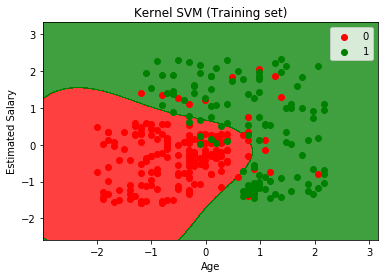

In [11]:
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Kernel SVM (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


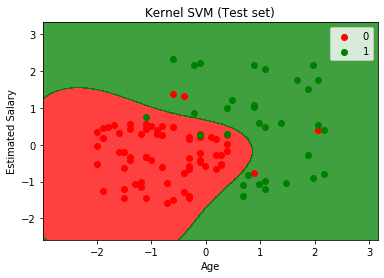

In [12]:
# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Kernel SVM (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()